<a href="https://colab.research.google.com/github/M1-KO/Spaceship-Titanic/blob/main/Spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data**

In [ ]:
!pip install opendatasets
!pip install kaggle
!pip install ydata-profiling
!pip3 install optuna
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score
import xgboost as xgb
import optuna
from optuna.integration import CatBoostPruningCallback
import catboost as cb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset_url = 'https://www.kaggle.com/competitions/spaceship-titanic/data'
od.download(dataset_url)

Skipping, found downloaded files in "./spaceship-titanic" (use force=True to force download)


In [ ]:
df_sample_submission = pd.read_csv('/content/spaceship-titanic/sample_submission.csv')
df_train = pd.read_csv('/content/spaceship-titanic/train.csv')
df_test = pd.read_csv('/content/spaceship-titanic/test.csv')

In [ ]:
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [ ]:
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [ ]:
df_sample_submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [ ]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [ ]:
df_test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [ ]:
df_sample_submission.describe()


,PassengerId,Transported
count,4277,4277
unique,4277,1
top,0013_01,False
freq,1,4277


### Columns names, number of data, non-null count and data type

In [ ]:
print("df_train info: \n")
print(f"{df_train.info()} \n")
print("df_test info: \n")
print(f"{df_test.info()} \n")
print("df_sample_submission info: \n")
print(f"{df_sample_submission.info()}")

df_train info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None 

df_test info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 colum

### Missing values

In [ ]:
print("df_train missing values: \n")
print(f"{df_train.isna().sum().sort_values()} \n")
print("df_test missing values: \n")
print(f"{df_test.isna().sum().sort_values()} \n")
print("df_sample_submission missing values: \n")
print(f"{df_sample_submission.isna().sum().sort_values()} \n")

df_train missing values: 

PassengerId       0
Transported       0
Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
Cabin           199
Name            200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64 

df_test missing values: 

PassengerId       0
VRDeck           80
RoomService      82
HomePlanet       87
Age              91
Destination      92
CryoSleep        93
VIP              93
Name             94
ShoppingMall     98
Cabin           100
Spa             101
FoodCourt       106
dtype: int64 

df_sample_submission missing values: 

PassengerId    0
Transported    0
dtype: int64 



### Unique values

In [ ]:
print("Unique values in df_train: \n")
print(f"{df_train.nunique()} \n")
print("Unique values in df_test: \n")
print(f"{df_test.nunique()} \n")
print("Unique values in df_sample_submission: \n")
print(f"{df_sample_submission.nunique()} \n")

Unique values in df_train: 

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64 

Unique values in df_test: 

PassengerId     4277
HomePlanet         3
CryoSleep          2
Cabin           3265
Destination        3
Age               79
VIP                2
RoomService      842
FoodCourt        902
ShoppingMall     715
Spa              833
VRDeck           796
Name            4176
dtype: int64 

Unique values in df_sample_submission: 

PassengerId    4277
Transported       1
dtype: int64 



# **EDA**

<AxesSubplot: >

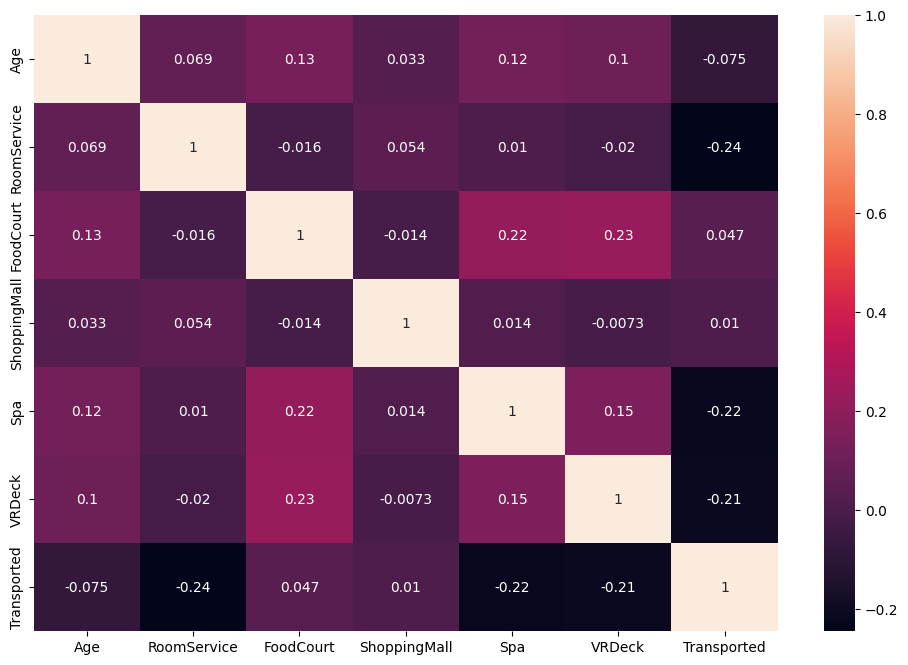

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train.corr(), annot=True)

<AxesSubplot: xlabel='Transported', ylabel='count'>

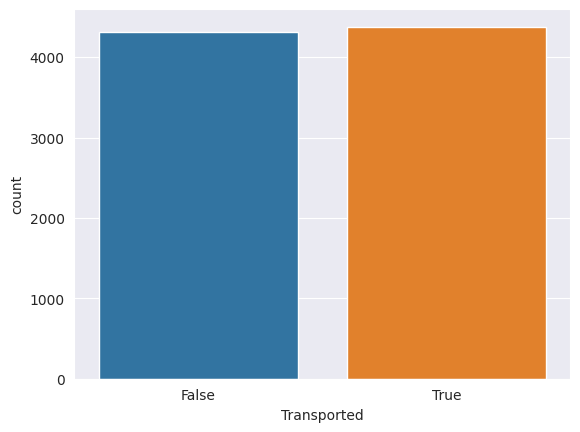

In [ ]:
sns.set_style("darkgrid")

sns.countplot(data=df_train, x="Transported")

### Categorial columns

<AxesSubplot: xlabel='HomePlanet', ylabel='count'>

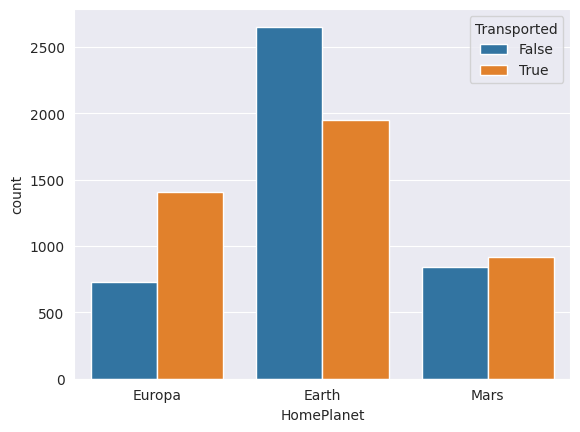

In [ ]:
sns.countplot(data=df_train, x="HomePlanet", hue="Transported")

<AxesSubplot: xlabel='CryoSleep', ylabel='count'>

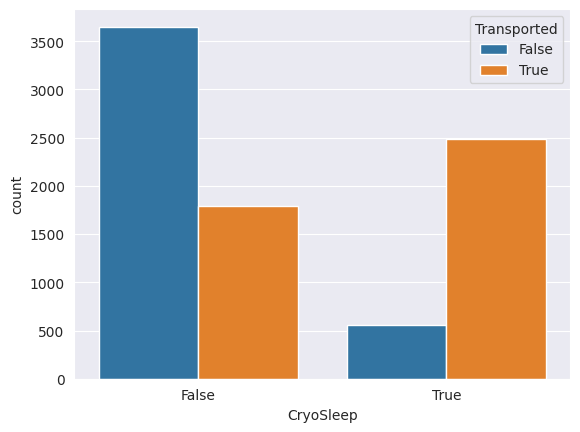

In [ ]:
sns.countplot(data=df_train, x="CryoSleep", hue="Transported")

<AxesSubplot: xlabel='Destination', ylabel='count'>

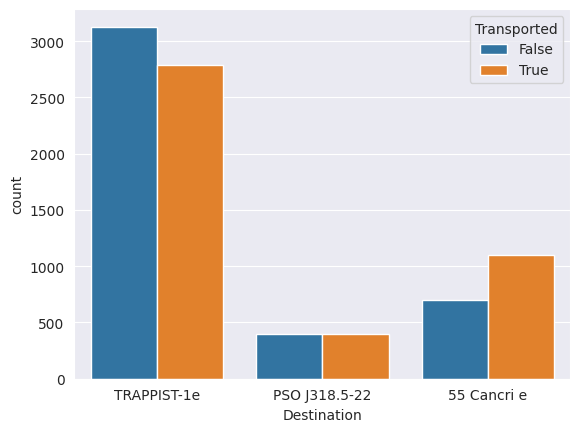

In [ ]:
sns.countplot(data=df_train, x="Destination", hue="Transported")

<AxesSubplot: xlabel='VIP', ylabel='count'>

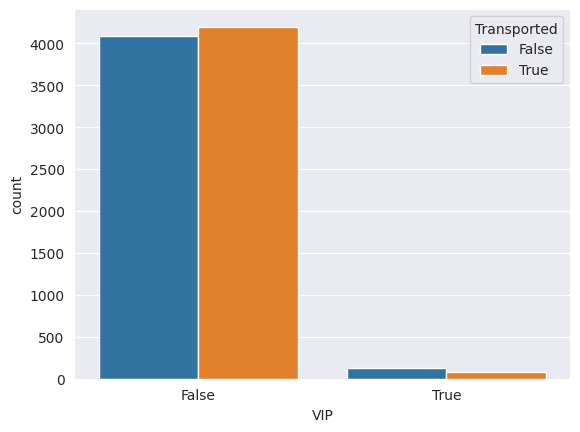

In [ ]:
sns.countplot(data=df_train, x=df_train["VIP"], hue="Transported")

### Numerical columns


In [ ]:
# pair_grid = sns.PairGrid(df_train, hue="Transported")
# pair_grid.map(sns.scatterplot)

<AxesSubplot: xlabel='Age', ylabel='Count'>

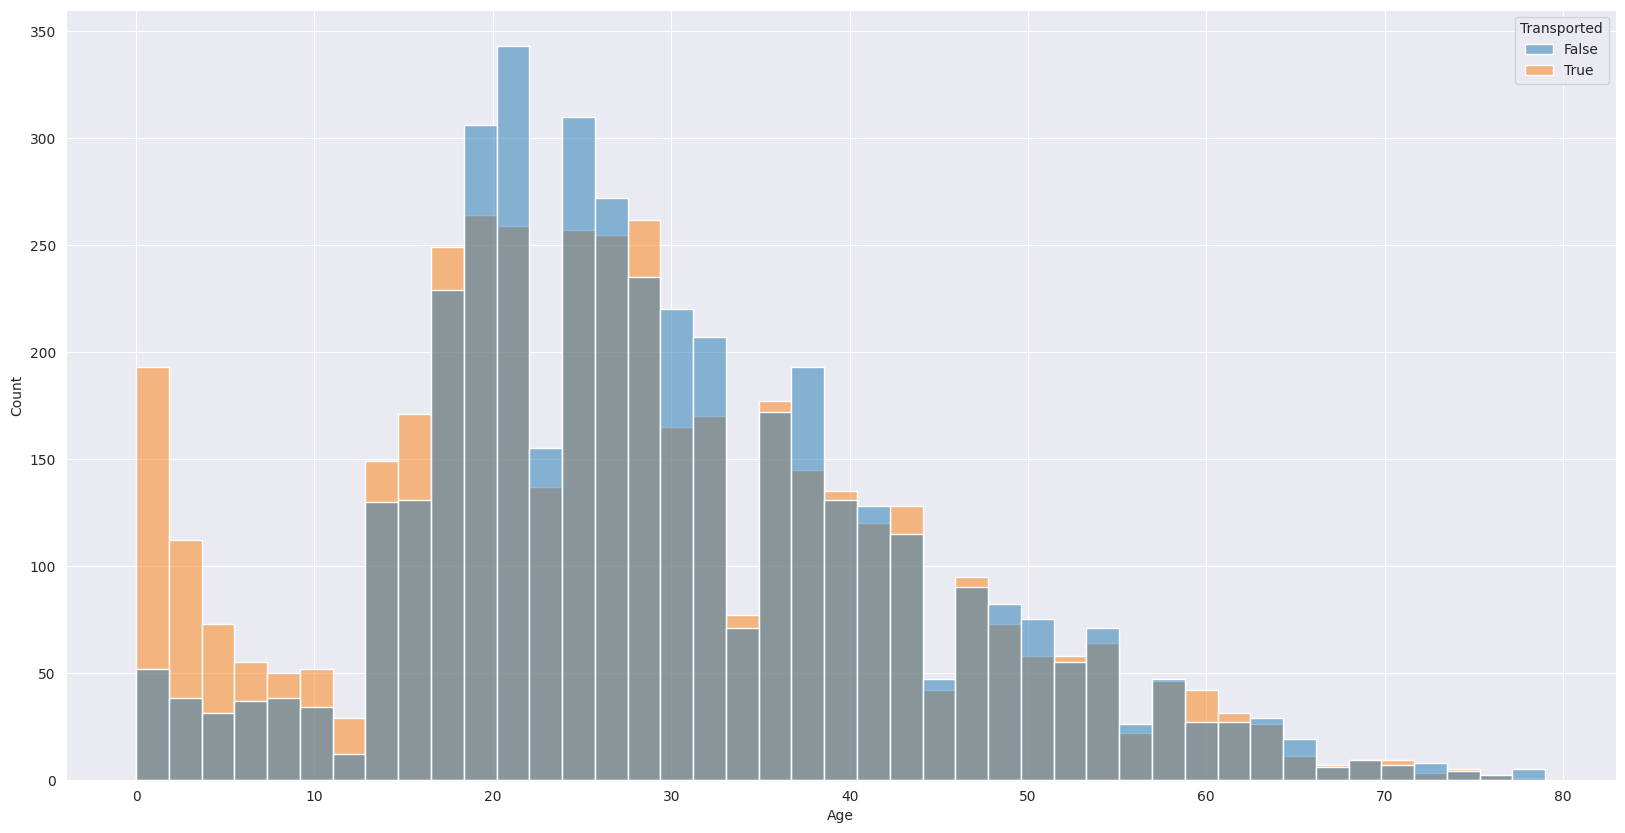

In [ ]:
plt.figure(figsize=(20,10))
sns.histplot(data=df_train, x="Age", hue="Transported")

<AxesSubplot: xlabel='Age'>

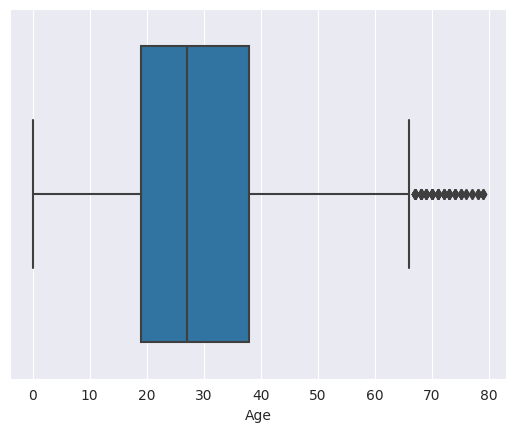

In [ ]:
sns.boxplot(data=df_train, x="Age", hue="Transported")

In [ ]:
num_col = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

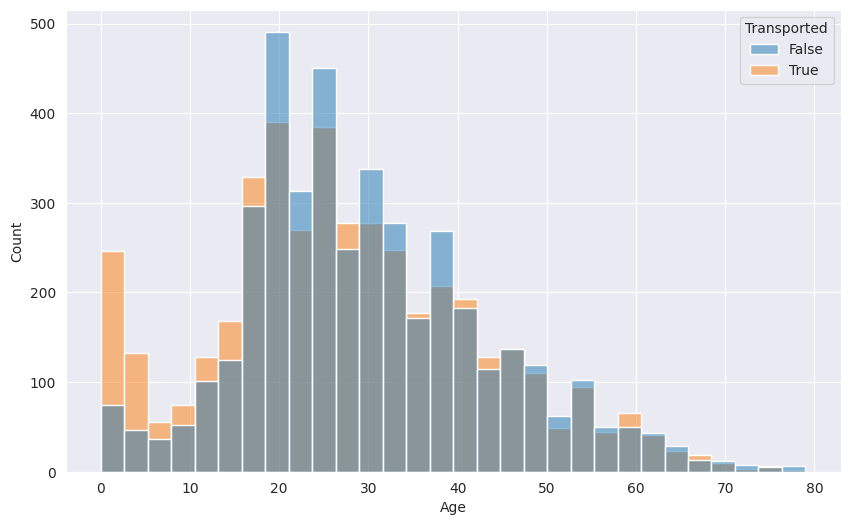

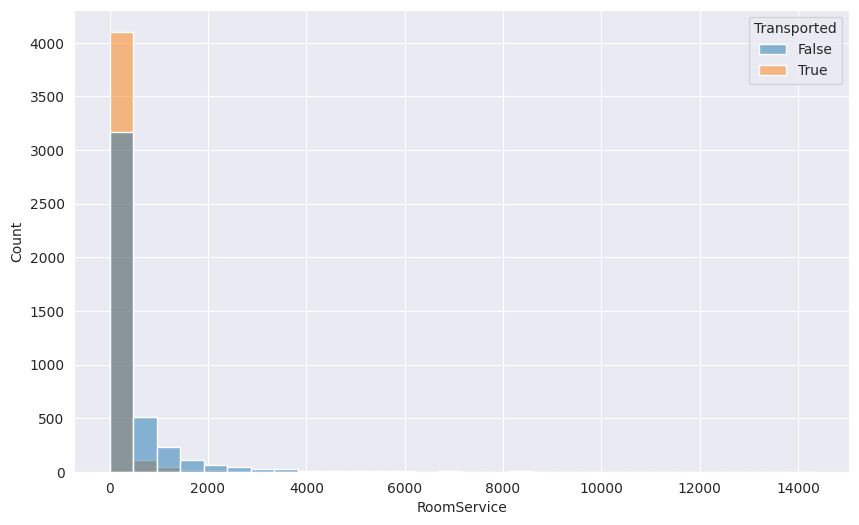

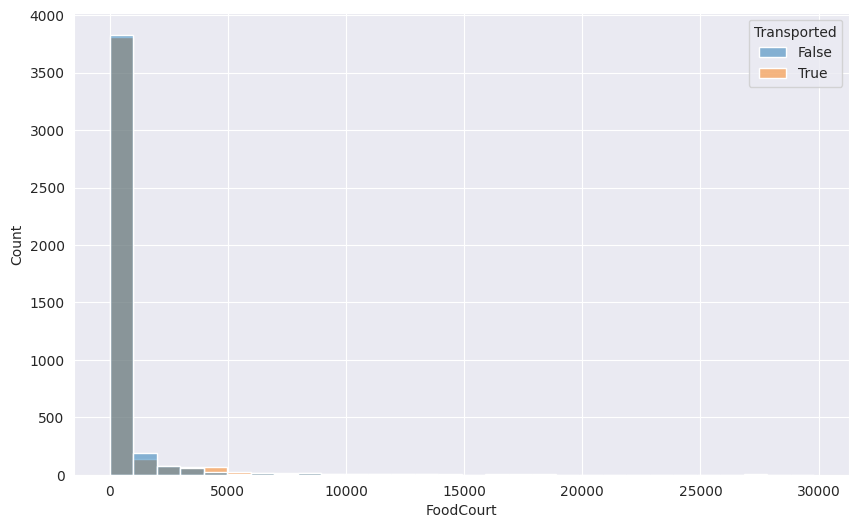

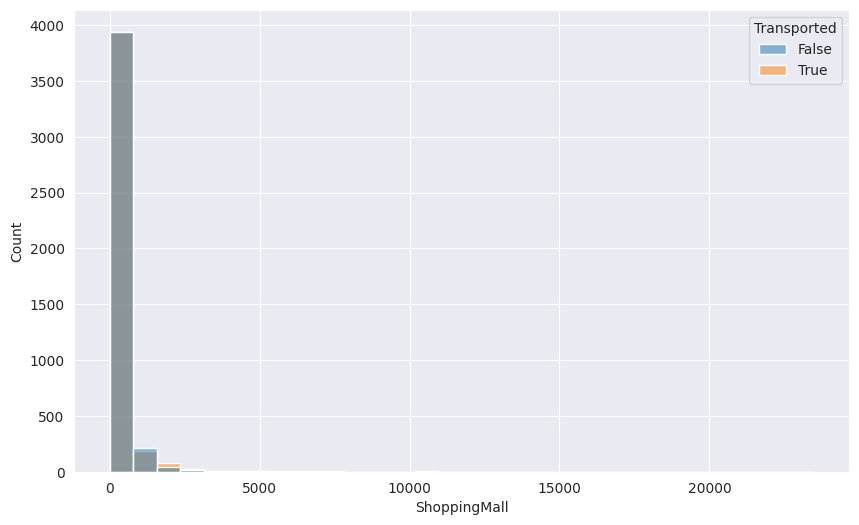

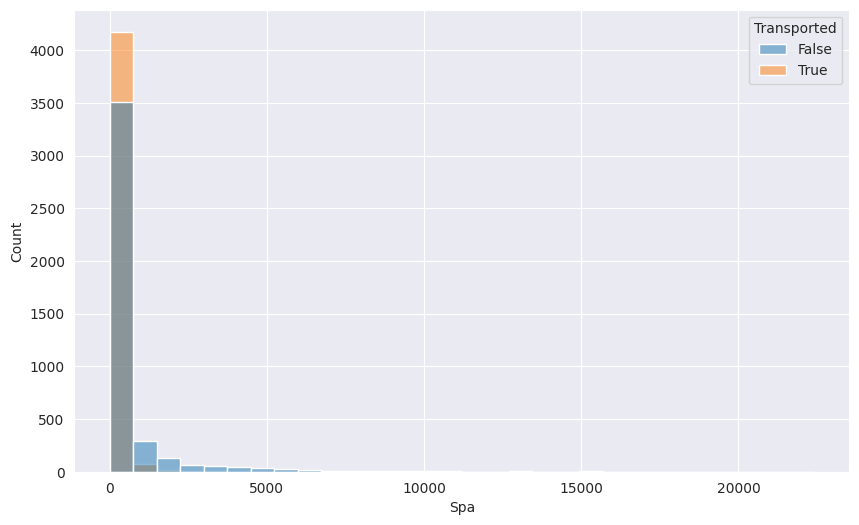

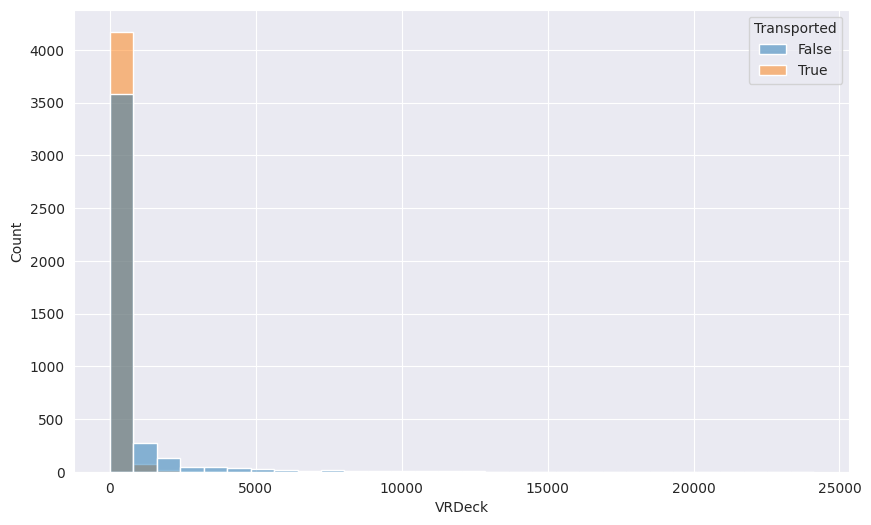

In [ ]:
for i, name in enumerate(num_col):
  plt.figure(figsize=(10,6))
  sns.histplot(data=df_train, x=name, bins=30, kde=False, hue='Transported')

### Age vs Expenses

In [ ]:
expenses_col = df_train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

<AxesSubplot: xlabel='Age'>

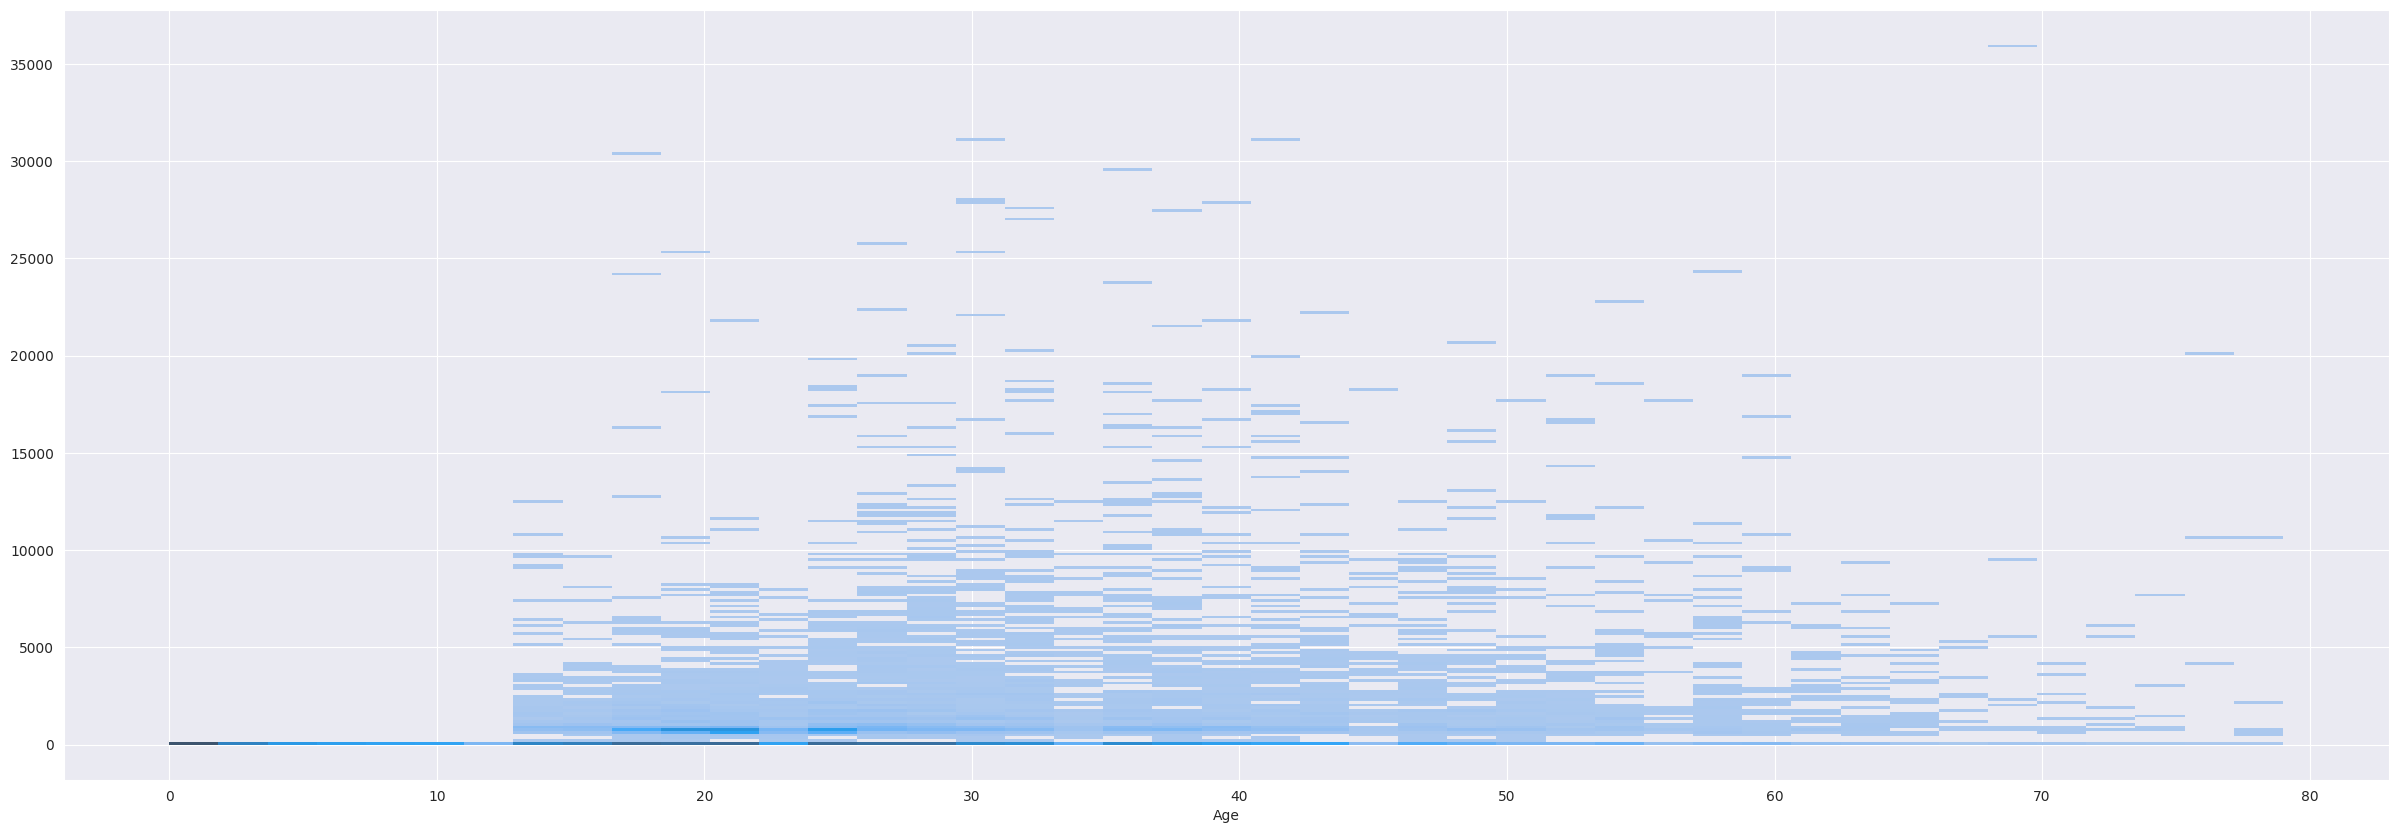

In [ ]:
plt.figure(figsize=(30,10))
sns.histplot(data=df_train, x="Age", y=expenses_col)

<AxesSubplot: xlabel='Age'>

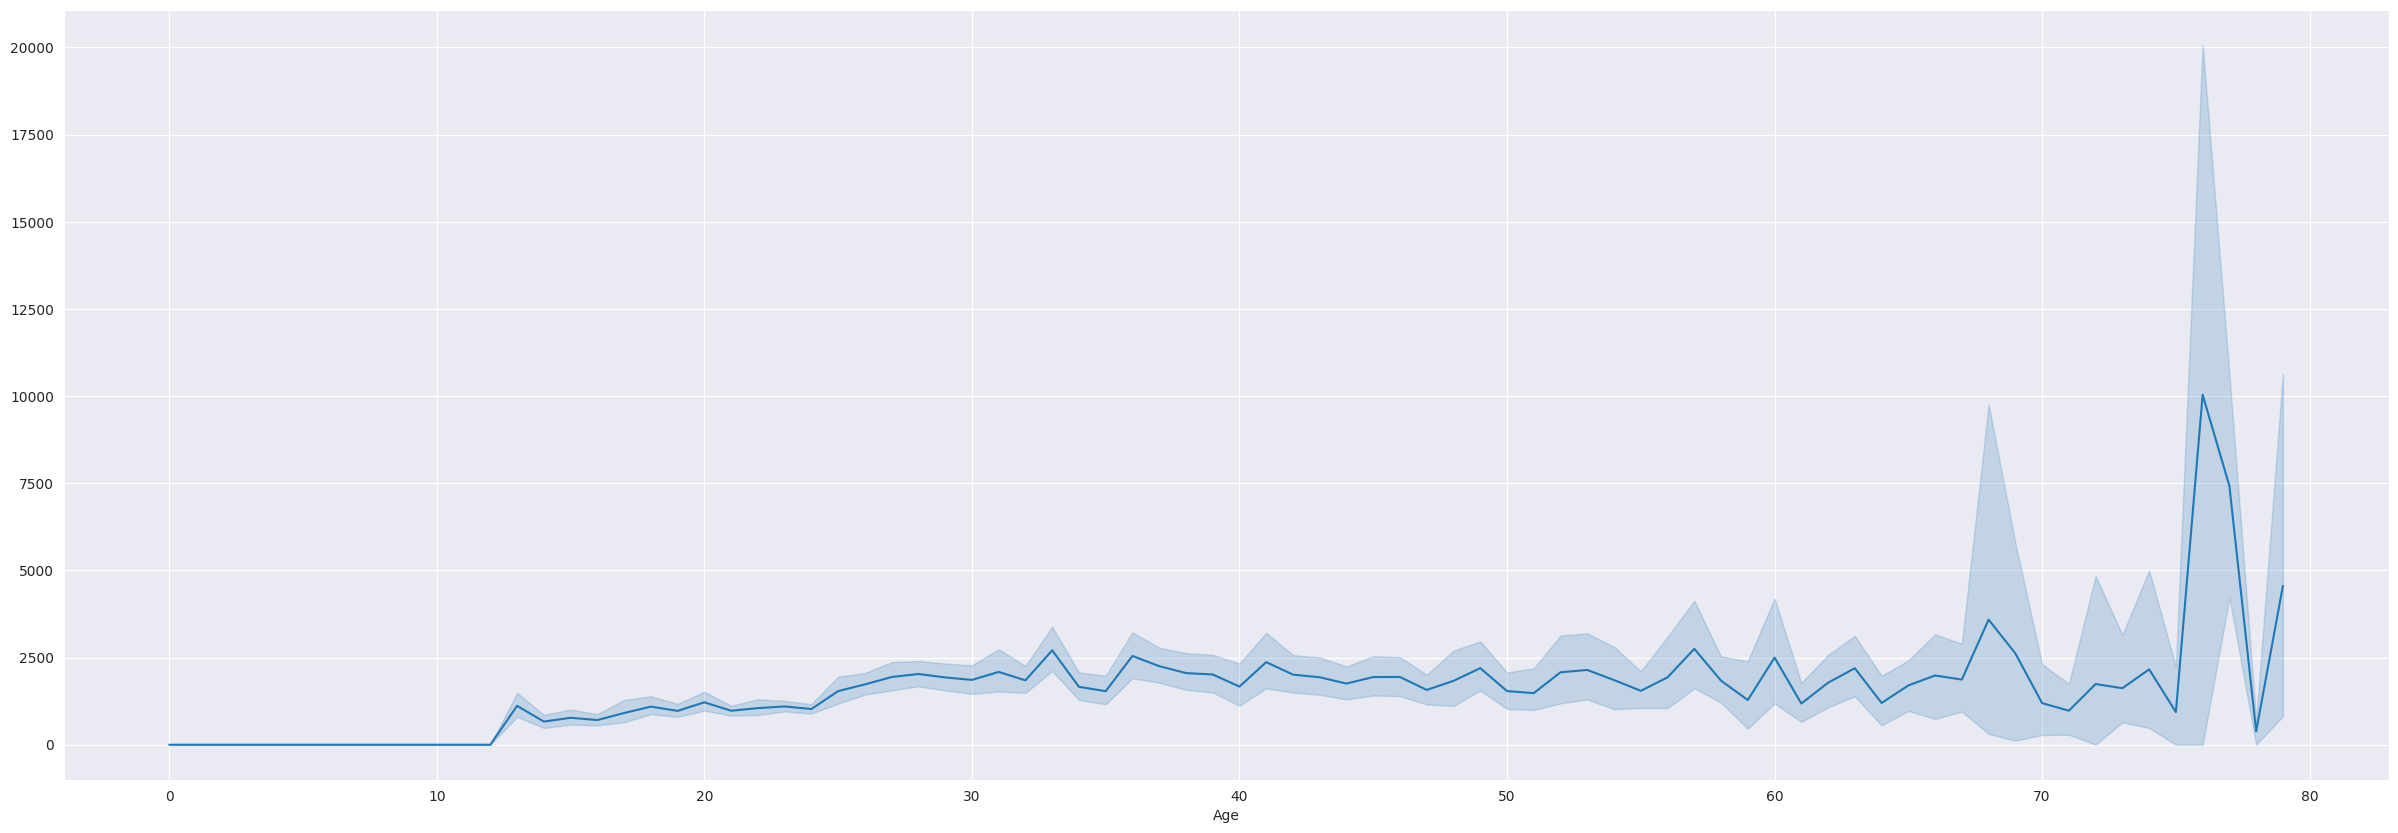

In [ ]:
plt.figure(figsize=(30,10))
sns.lineplot(data=df_train, x="Age", y=expenses_col)

<AxesSubplot: xlabel='Age'>

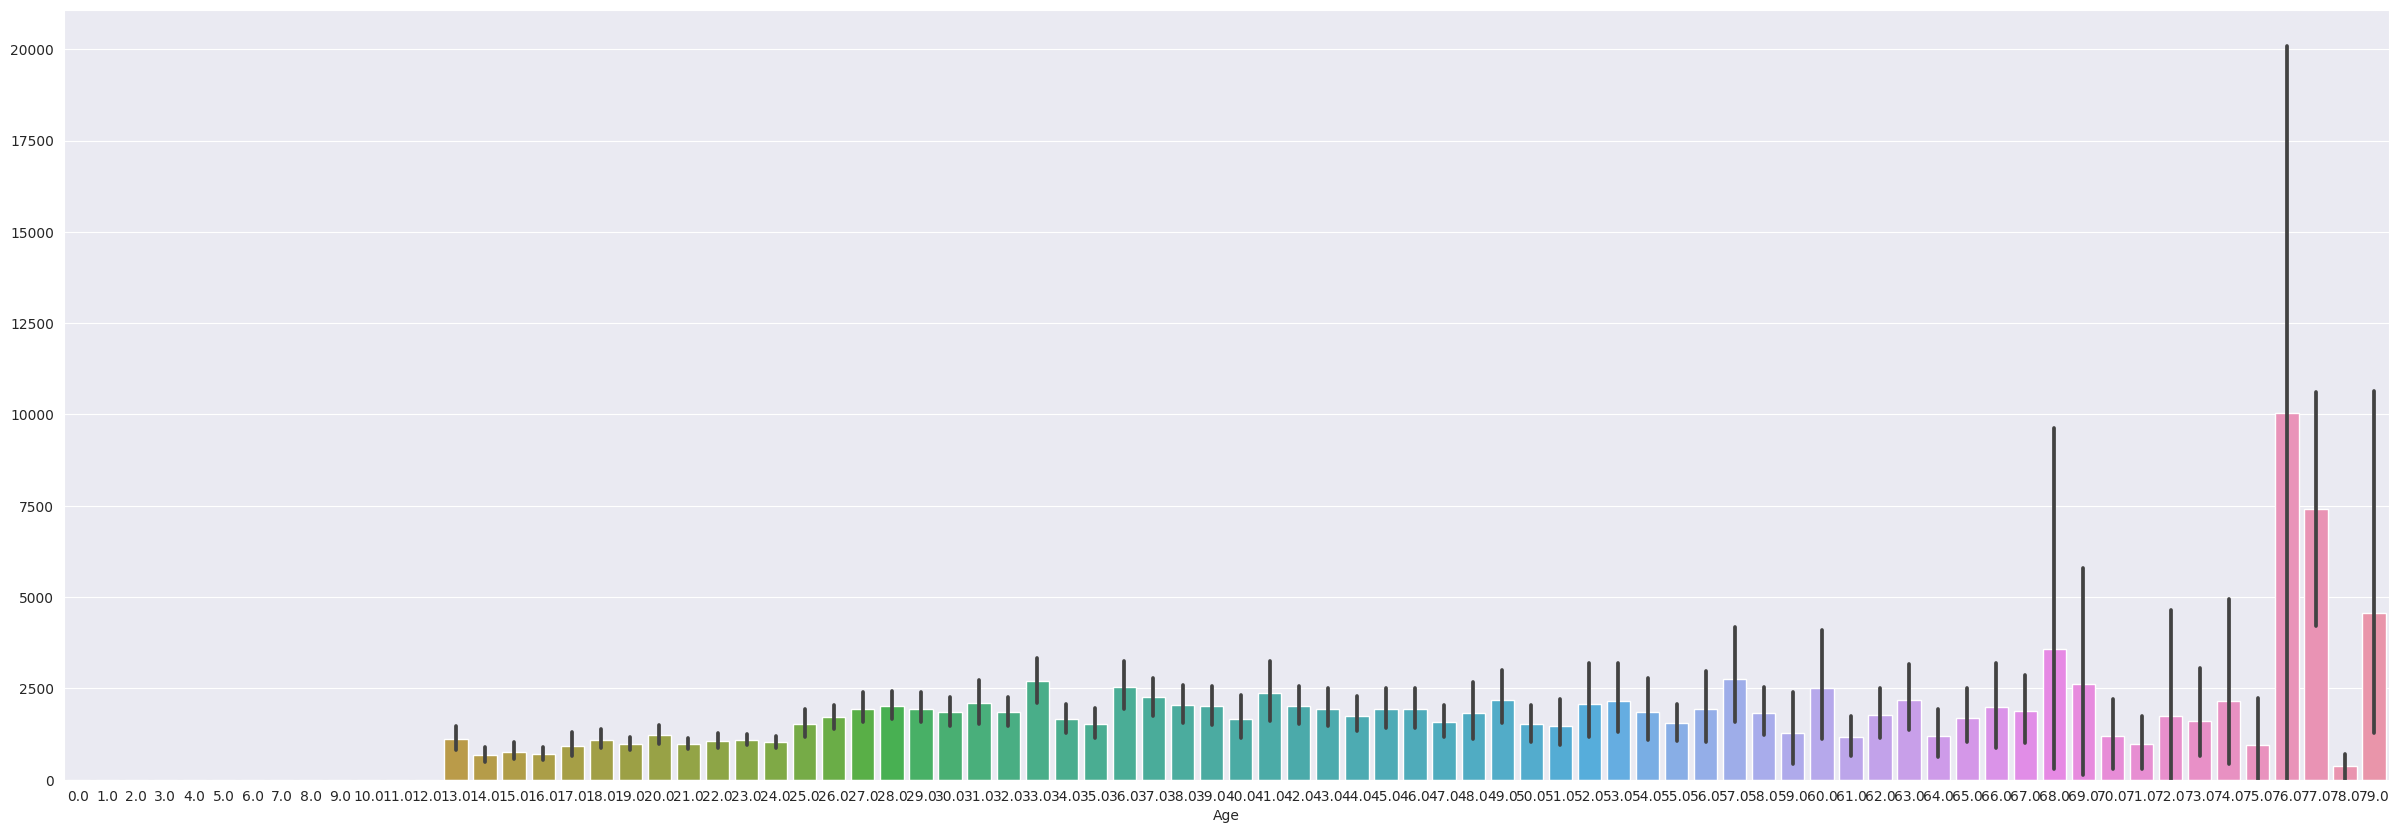

In [ ]:
plt.figure(figsize=(30,10))
sns.barplot(data=df_train, x="Age", y=expenses_col)

<AxesSubplot: xlabel='Age'>

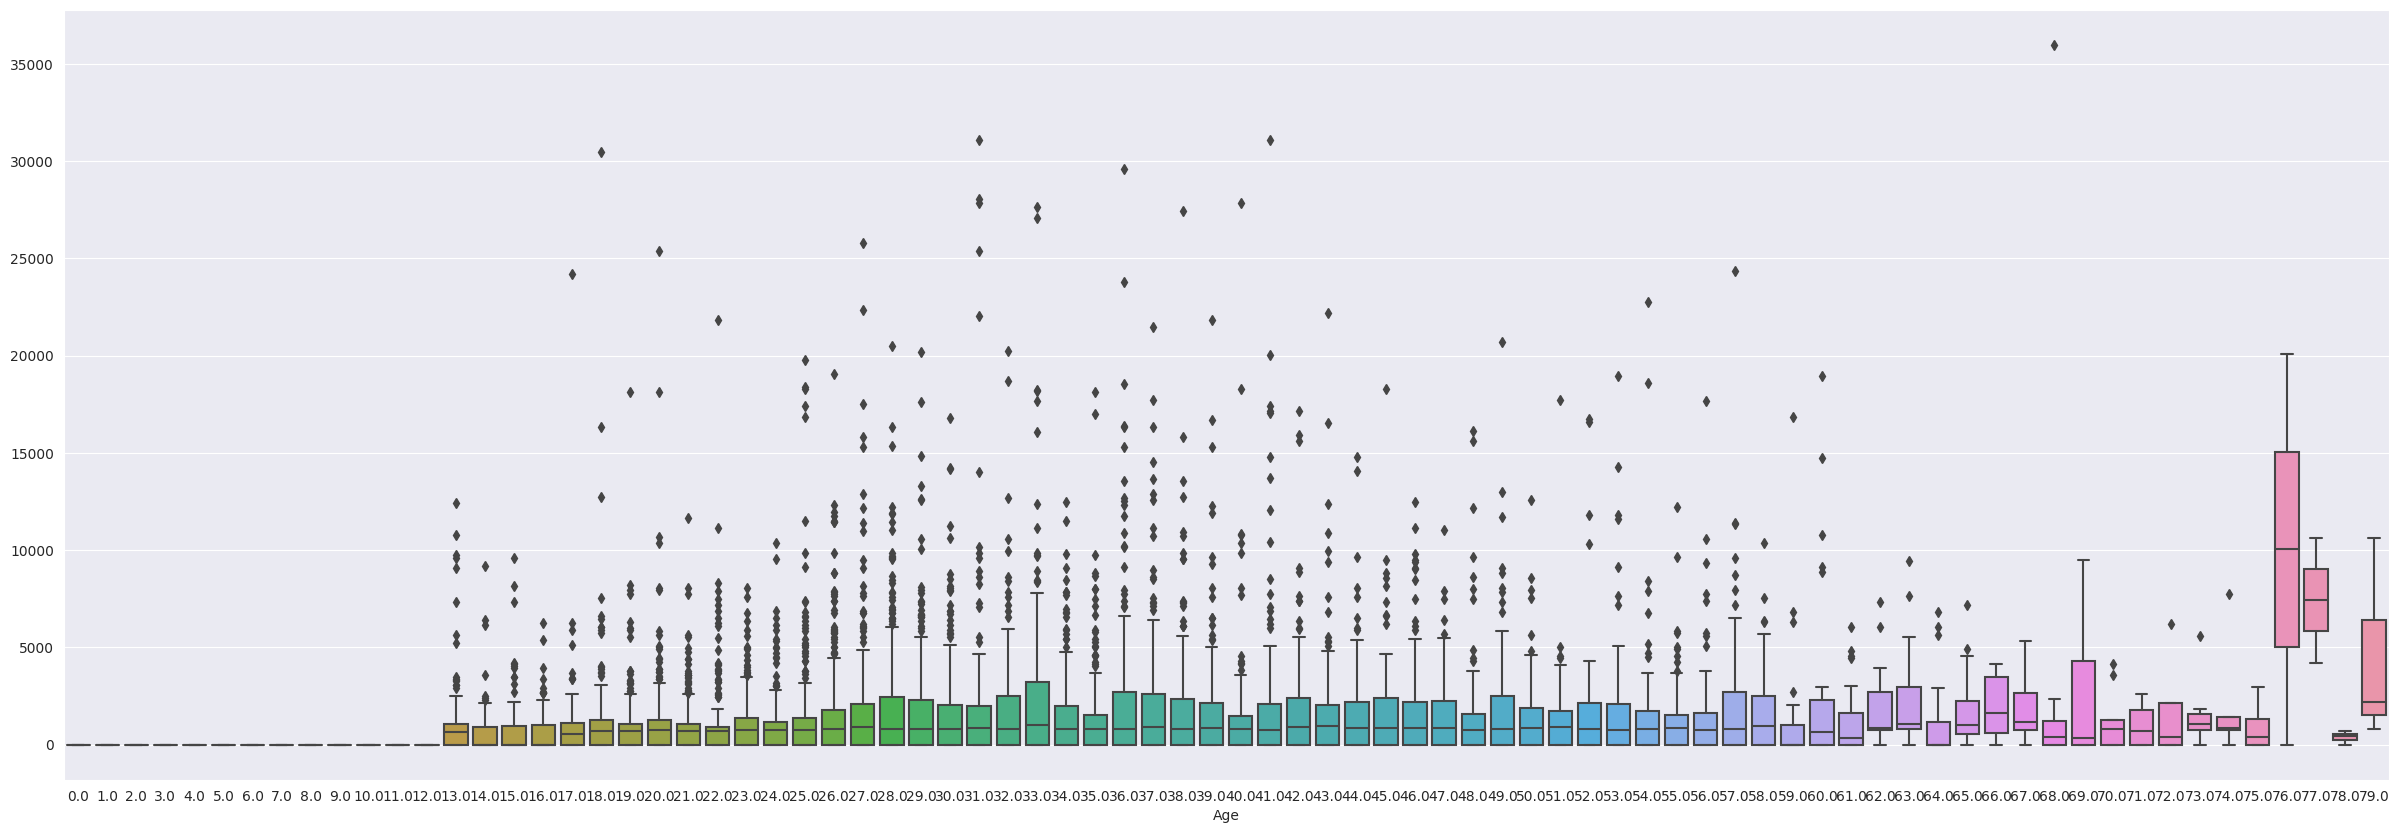

In [ ]:
plt.figure(figsize=(30,10))
sns.boxplot(data=df_train, x="Age", y=expenses_col)

In [ ]:
df_train["Age"].describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

In [ ]:
df_train["Age"].value_counts()

24.0    324
18.0    320
21.0    311
19.0    293
23.0    292
       ... 
72.0      4
78.0      3
79.0      3
76.0      2
77.0      2
Name: Age, Length: 80, dtype: int64

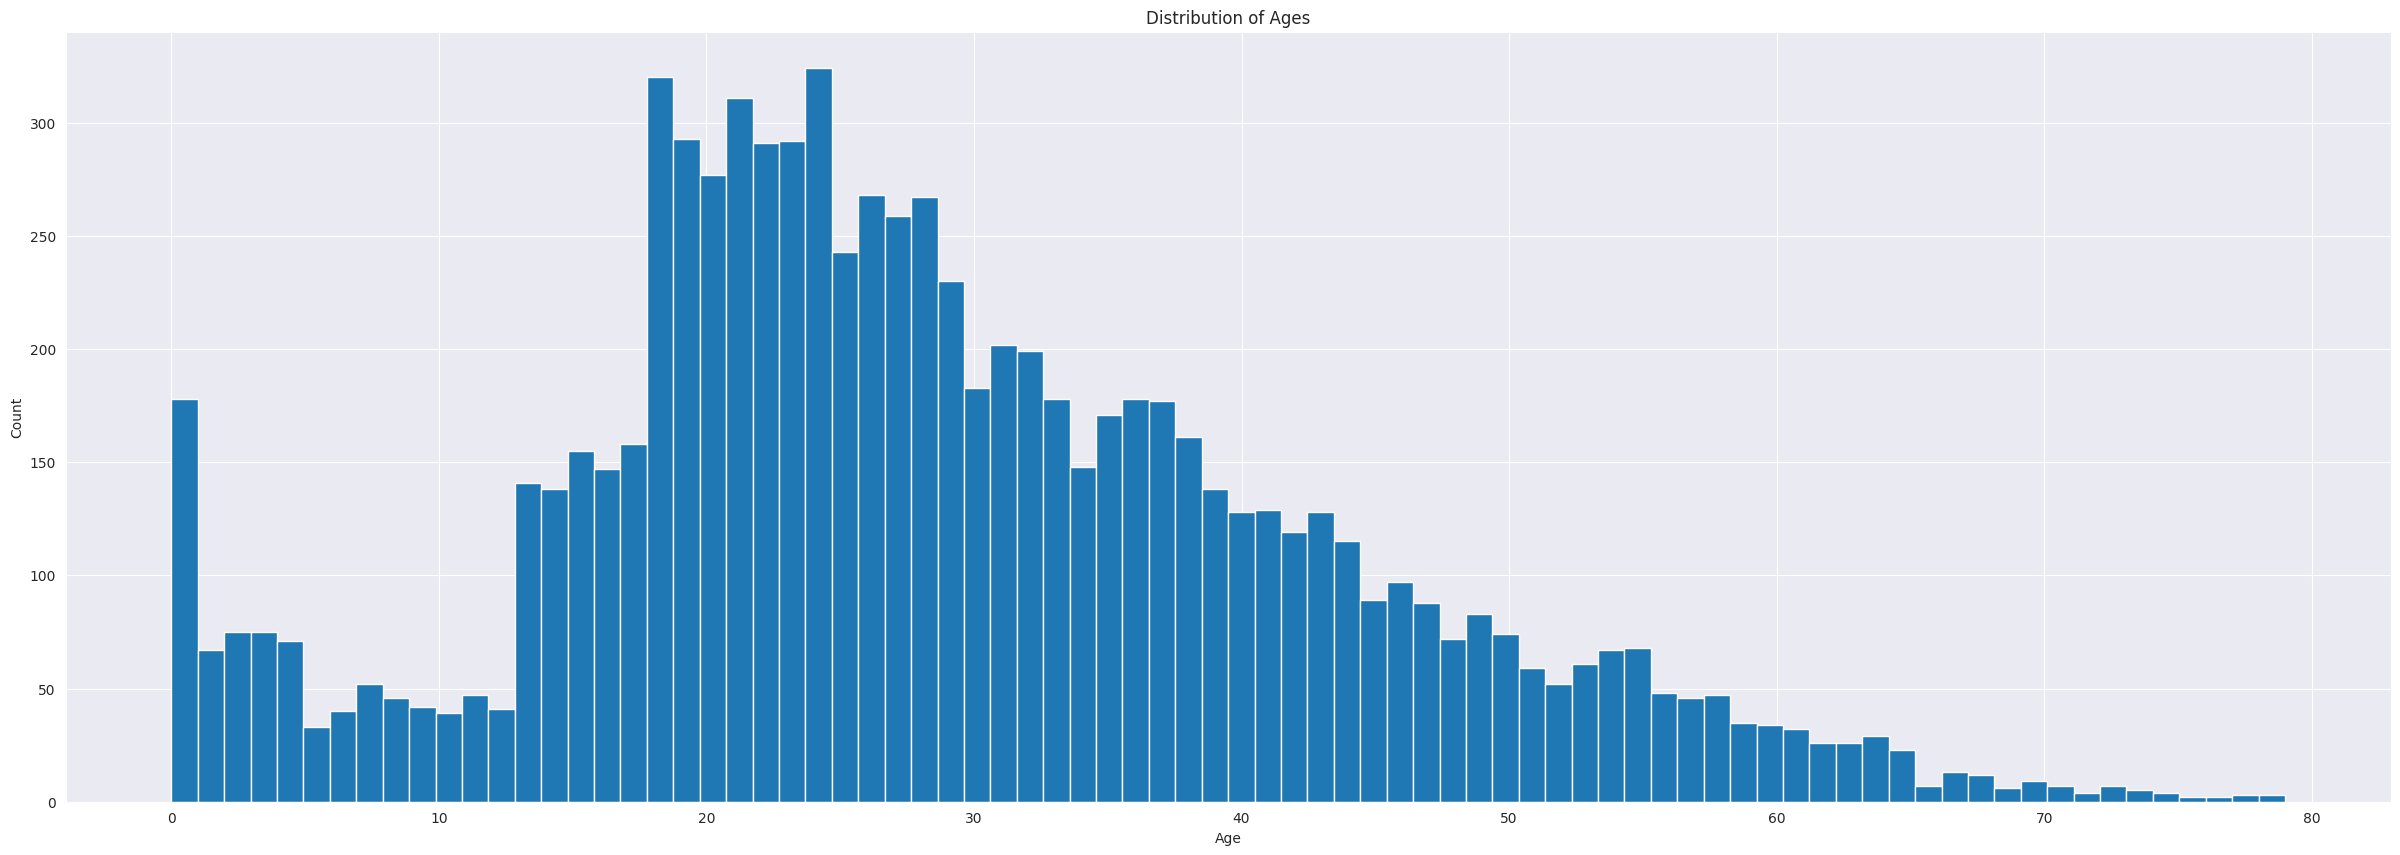

In [ ]:
plt.figure(figsize=(30,10))
plt.hist(df_train['Age'], bins=80)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')
plt.show()

### Cabin

In [ ]:
df_train["Cabin"]

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [ ]:
df_train[["Deck", "Num", "Side"]] = df_train["Cabin"].str.split("/", expand=True)

<AxesSubplot: xlabel='Deck', ylabel='count'>

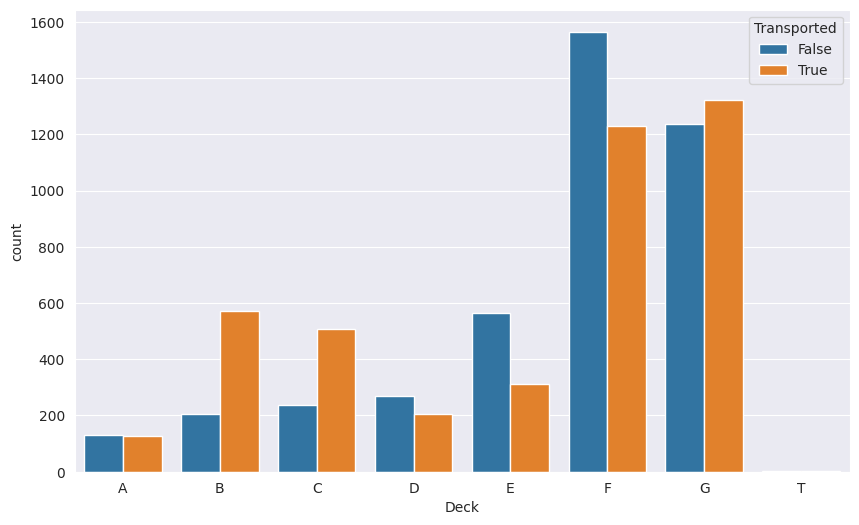

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_train, x="Deck", hue="Transported", order=['A','B','C','D','E','F','G','T'])

<AxesSubplot: xlabel='Num', ylabel='Count'>

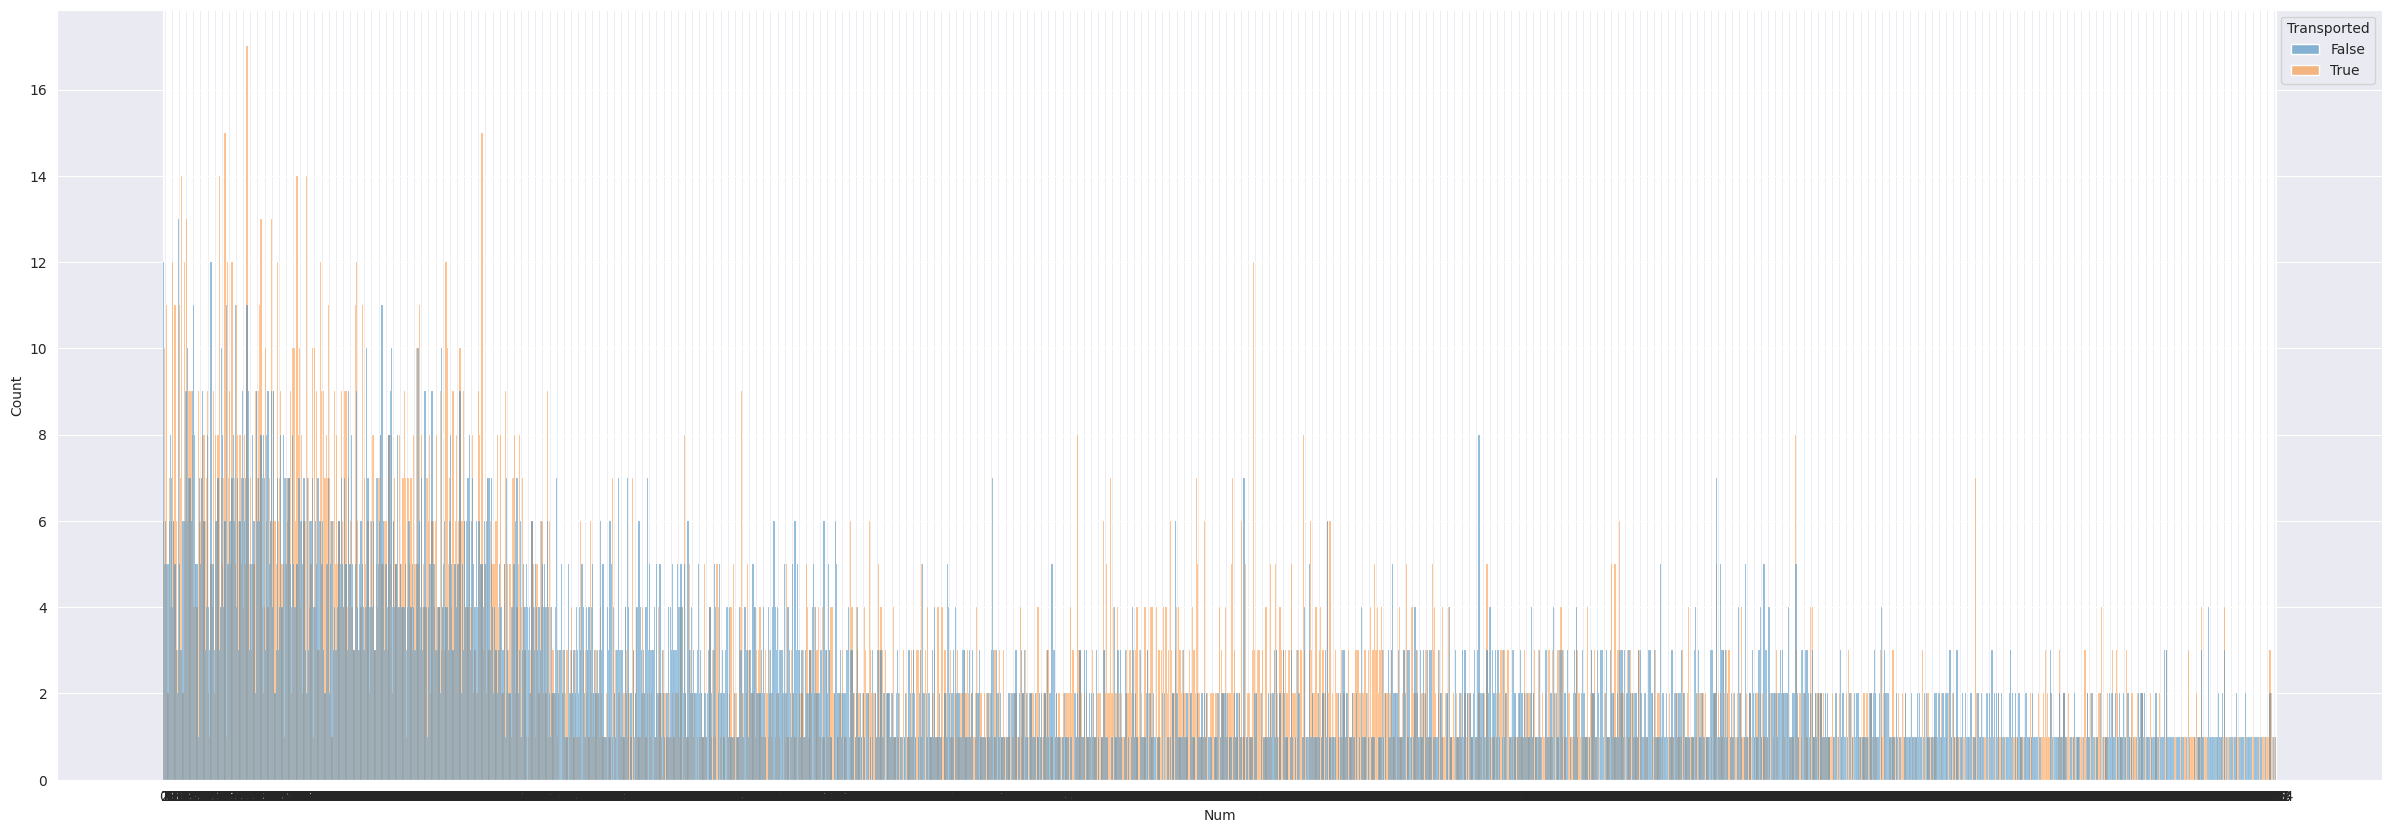

In [ ]:
plt.figure(figsize=(30,10))
sns.histplot(data=df_train, x="Num", hue="Transported")

<AxesSubplot: xlabel='Side', ylabel='count'>

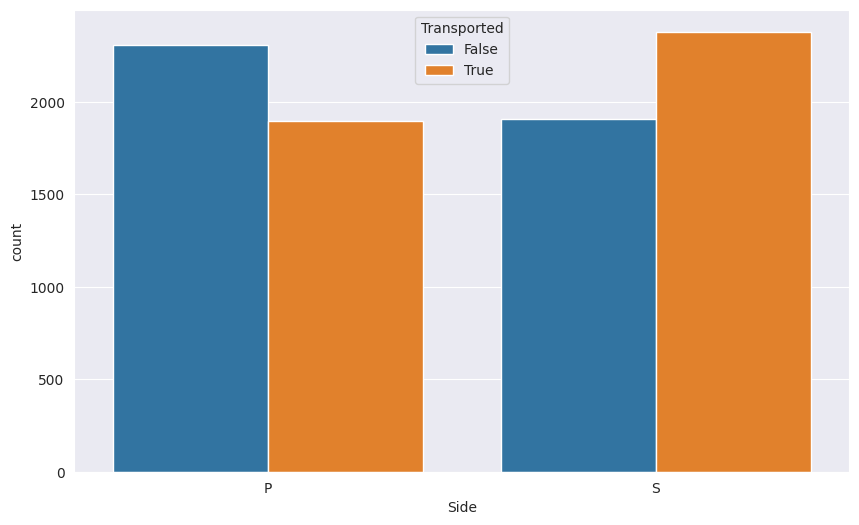

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_train, x="Side", hue="Transported")

In [ ]:
# prof = ProfileReport(df_train)
# prof.to_file(output_file='EDA_report.html')

# Feature Engineering & Preprocessing

In [ ]:
# df_train = pd.read_csv('/content/spaceship-titanic/train.csv')
# df_train[["Deck", "Num", "Side"]] = df_train["Cabin"].str.split("/", expand=True)

In [ ]:
# df_train["AgeGroup"]=np.nan
# df_train.loc[df_train["Age"]<=12,'AgeGroup']='Age_0-12'
# df_train.loc[(df_train["Age"]>12) & (df_train["Age"]<18),'Age_group']='Age_13-17'
# df_train.loc[(df_train["Age"]>=18) & (df_train["Age"]<=25),'Age_group']='Age_18-25'
# df_train.loc[(df_train["Age"]>25) & (df_train["Age"]<=30),'Age_group']='Age_26-30'
# df_train.loc[(df_train["Age"]>30) & (df_train["Age"]<=50),'Age_group']='Age_31-50'
# df_train.loc[df_train["Age"]>50,"AgeGroup"]="Age_51+"

In [ ]:
# medians = df_train.loc[df_train["Age"] > 12, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].median()

# df_train.loc[df_train["Age"] > 12, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = \
#     df_train.loc[df_train["Age"] > 12, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].fillna(medians)

In [ ]:
# df_train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].median()

I wanted to be clever but it turned out that the median over 12 years is also 0 :D So you can just replace NaN values with overall median

In [ ]:
df_test[["Deck", "Num", "Side"]] = df_test["Cabin"].str.split("/", expand=True)

In [ ]:
for col in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    df_train[col].fillna(df_train[col].median(), inplace=True)
    df_test[col].fillna(df_test[col].median(), inplace=True)

In [ ]:
df_train['VIP'] = df_train['VIP'].fillna(False)
df_test['VIP'] = df_test['VIP'].fillna(False)

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')
cat_cols = ["CryoSleep", "Side"]
df_train[cat_cols] = imputer.fit_transform(df_train[cat_cols])
df_test[cat_cols] = imputer.fit_transform(df_test[cat_cols])



In [ ]:
bool_cols_train = ["CryoSleep", "VIP", "Transported"]
bool_cols_test = ["CryoSleep", "VIP"]

# Convert boolean columns to binary values
df_train[bool_cols_train] = df_train[bool_cols_train].astype(int)
df_test[bool_cols_test] = df_test[bool_cols_test].astype(int)

In [ ]:
df_sample_submission["Transported"] = df_sample_submission["Transported"].astype(int)

In [ ]:
ohe_col = ['HomePlanet', 'Destination', 'Deck', 'Side']
df_train = pd.get_dummies(df_train, columns= ohe_col)
df_test = pd.get_dummies(df_test, columns= ohe_col)

In [ ]:
df_train = df_train.drop(['PassengerId', 'Cabin', 'Name'],axis=1)
df_test = df_test.drop(['PassengerId', 'Cabin', 'Name'],axis=1)

In [ ]:
df_train = df_train.drop(['Num'],axis=1)
df_test = df_test.drop(['Num'],axis=1)

In [ ]:
df_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,...,0,0,0,0,0,1,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,0,...,1,0,0,0,0,0,0,0,1,0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,1
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,1,...,0,0,0,0,0,0,1,0,0,1
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
df_test

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,1,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,34.0,0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,1,0,0,1
4273,0,42.0,0,0.0,847.0,17.0,10.0,144.0,1,0,...,0,0,0,0,0,0,0,0,0,1
4274,1,NaN,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
4275,0,NaN,0,0.0,2680.0,0.0,0.0,523.0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
print("df_train missing values: \n")
print(f"{df_train.isna().sum().sort_values()} \n")
print("df_test missing values: \n")
print(f"{df_test.isna().sum().sort_values()} \n")

df_train missing values: 

CryoSleep                      0
Deck_T                         0
Deck_G                         0
Deck_F                         0
Deck_E                         0
Deck_D                         0
Deck_C                         0
Deck_B                         0
Deck_A                         0
Destination_TRAPPIST-1e        0
Destination_PSO J318.5-22      0
Side_P                         0
Destination_55 Cancri e        0
HomePlanet_Europa              0
HomePlanet_Earth               0
Transported                    0
VRDeck                         0
Spa                            0
ShoppingMall                   0
FoodCourt                      0
RoomService                    0
VIP                            0
HomePlanet_Mars                0
Side_S                         0
Age                          179
dtype: int64 

df_test missing values: 

CryoSleep                     0
Deck_T                        0
Deck_G                        0
Deck_F     

In [ ]:
print("Unique values in df_train: \n")
print(f"{df_train.nunique()} \n")
print("Unique values in df_test: \n")
print(f"{df_test.nunique()} \n")

Unique values in df_train: 

CryoSleep                       2
Age                            80
VIP                             2
RoomService                  1273
FoodCourt                    1507
ShoppingMall                 1115
Spa                          1327
VRDeck                       1306
Transported                     2
HomePlanet_Earth                2
HomePlanet_Europa               2
HomePlanet_Mars                 2
Destination_55 Cancri e         2
Destination_PSO J318.5-22       2
Destination_TRAPPIST-1e         2
Deck_A                          2
Deck_B                          2
Deck_C                          2
Deck_D                          2
Deck_E                          2
Deck_F                          2
Deck_G                          2
Deck_T                          2
Side_P                          2
Side_S                          2
dtype: int64 

Unique values in df_test: 

CryoSleep                      2
Age                           79
VIP         

# **Modeling**

In [ ]:
# from pandas.core.common import random_state
X = df_train.drop('Transported', axis=1)
y = df_train['Transported']
X_test = df_test
y_test = df_sample_submission

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

### XGBoost

In [ ]:
# Create XGBoost classifier model
model = xgb.XGBClassifier(n_estimators=250, max_depth=2, learning_rate=0.15, objective='binary:logistic')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_val)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 78.55%


In [ ]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    }
    model = xgb.XGBClassifier(objective='binary:logistic', **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2023-04-09 18:59:42,165] A new study created in memory with name: no-name-24c8bff3-8fe3-4323-9973-0e908963ed28
[I 2023-04-09 18:59:43,196] Trial 0 finished with value: 0.7607820586543991 and parameters: {'n_estimators': 176, 'max_depth': 3, 'learning_rate': 0.0017472250171823662}. Best is trial 0 with value: 0.7607820586543991.
[I 2023-04-09 18:59:52,061] Trial 1 finished with value: 0.78953421506613 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.005830324883507935}. Best is trial 1 with value: 0.78953421506613.
[I 2023-04-09 18:59:54,811] Trial 2 finished with value: 0.7866589994249569 and parameters: {'n_estimators': 133, 'max_depth': 10, 'learning_rate': 0.011453933945486683}. Best is trial 1 with value: 0.78953421506613.
[I 2023-04-09 18:59:57,144] Trial 3 finished with value: 0.7768832662449684 and parameters: {'n_estimators': 426, 'max_depth': 3, 'learning_rate': 0.004600348222855924}. Best is trial 1 with value: 0.78953421506613.
[I 2023-04-09 19:00:

In [ ]:
best_params = study.best_params
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'n_estimators': 305, 'max_depth': 9, 'learning_rate': 0.06236648564972302}


In [ ]:
final_model = xgb.XGBClassifier(objective='binary:logistic', **best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))


Accuracy: 79.87%


In [ ]:
def objective(trial):
  X = df_train.drop('Transported', axis=1)
  y = df_train['Transported']
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)
  dtrain = xgb.DMatrix( X_train, label=y_train)
  dvalid = xgb.DMatrix(X_val, label=y_val)

  params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'gamma': trial.suggest_uniform('gamma', 0.0, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'random_state': 42
    }

  best = xgb.train(params, dtrain)
  preds = best.predict(dvalid)
  pred_labels = np.rint(preds)
  accuracy = accuracy_score(y_val, pred_labels)
  return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))


[I 2023-04-09 22:01:30,517] A new study created in memory with name: no-name-72957b41-90d5-4116-a11f-f500e7083998


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-09 22:01:32,010] Trial 0 finished with value: 0.7797584818861415 and parameters: {'learning_rate': 0.07916775590986931, 'gamma': 0.8362077822608169, 'max_depth': 7, 'subsample': 0.9106429404527178, 'colsample_bytree': 0.6046841511742285, 'reg_alpha': 0.6618041090063278, 'reg_lambda': 0.3616759016186678}. Best is trial 0 with value: 0.7797584818861415.
[I 2023-04-09 22:01:32,118] Trial 1 finished with value: 0.7740080506037953 and parameters: {'learning_rate': 0.0078102395579672775, 'gamma': 0.49263050523634133, 'max_depth': 4, 'subsample': 0.6437247940262208, 'colsample_bytree': 0.6546489853704442, 'reg_alpha': 0.6895872672289892, 'reg_lambda': 0.627323408481101}. Best is trial 0 with value: 0.7797584818861415.
[I 2023-04-09 22:01:32,274] Trial 2 finished with value: 0.7855089131684876 and parameters: {'learning_rate': 0.0462600921091659, 'gamma': 0.775745009156793, 'max_depth': 6, 'subsample': 0.778623134089798, 'colsample_bytree': 0.7598057209724645, 'reg_alpha': 0.0575445

In [ ]:
def objective(trial):
    X = df_train.drop('Transported', axis=1)
    y = df_train['Transported']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'gamma': trial.suggest_uniform('gamma', 0.0, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
    }
    
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        nfold=5,
        early_stopping_rounds=10,
        metrics='auc',
        seed=42
    )

    return cv_results['test-auc-mean'].iloc[-1]

np.random.seed(0)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2023-04-09 22:11:41,501] A new study created in memory with name: no-name-f68423f4-7663-497d-b267-04f946911a86


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-09 22:12:13,192] Trial 0 finished with value: 0.887862588770348 and parameters: {'learning_rate': 0.0106096938542187, 'gamma': 0.6740856797743736, 'max_depth': 4, 'subsample': 0.9034034979371982, 'colsample_bytree': 0.6350683758705367, 'reg_alpha': 0.7611287678475707, 'reg_lambda': 0.9692552905698508}. Best is trial 0 with value: 0.887862588770348.
[I 2023-04-09 22:12:20,493] Trial 1 finished with value: 0.8867880818582421 and parameters: {'learning_rate': 0.03322026905866402, 'gamma': 0.09289529614264957, 'max_depth': 8, 'subsample': 0.9049080456798497, 'colsample_bytree': 0.7848317189863767, 'reg_alpha': 0.9011392254684629, 'reg_lambda': 0.3598108477354619}. Best is trial 0 with value: 0.887862588770348.
[I 2023-04-09 22:12:39,650] Trial 2 finished with value: 0.8828263090742917 and parameters: {'learning_rate': 0.024040152781661463, 'gamma': 0.6997892721063452, 'max_depth': 2, 'subsample': 0.5424280744405034, 'colsample_bytree': 0.8013583368281177, 'reg_alpha': 0.44318458

In [ ]:
# Number of finished trials:  100
# Best trial:
#   Value: 0.8896095918525828
#   Params: 
#     learning_rate: 0.04162215001642178
#     gamma: 0.8265870625819639
#     max_depth: 7
#     subsample: 0.5954316438509146
#     colsample_bytree: 0.6870518051224338
#     reg_alpha: 0.18002444799030679
#     reg_lambda: 0.5205151892953799

In [ ]:
# https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_cv.py

In [ ]:
SEED = 42
N_FOLDS = 5
CV_RESULT_DIR = "./xgboost_cv_results"


def objective(trial):
    X = df_train.drop('Transported', axis=1)
    y = df_train['Transported']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=1000,
        nfold=N_FOLDS,
        stratified=True,
        early_stopping_rounds=10,
        seed=SEED,
        verbose_eval=False,
    )

    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))

    # Save cross-validation results.
    filepath = os.path.join(CV_RESULT_DIR, "{}.csv".format(trial.number))
    xgb_cv_results.to_csv(filepath, index=False)

    # Extract the best score.
    best_score = xgb_cv_results["test-auc-mean"].values[-1]
    return best_score


if __name__ == "__main__":
    if not os.path.exists(CV_RESULT_DIR):
        os.mkdir(CV_RESULT_DIR)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

    shutil.rmtree(CV_RESULT_DIR)

[I 2023-04-11 09:15:35,114] A new study created in memory with name: no-name-b2f78bd9-71ae-4c69-92af-1d61eacfdac3


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-11 09:15:41,349] Trial 0 finished with value: 0.7737395663859201 and parameters: {'booster': 'dart', 'lambda': 0.010480522080475127, 'alpha': 0.0021163283563204447, 'subsample': 0.7996971213074264, 'colsample_bytree': 0.3833383326225736, 'max_depth': 1, 'min_child_weight': 2, 'eta': 0.0003948551819664389, 'gamma': 7.309666804572829e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.478373111022199, 'skip_drop': 5.643863154036918e-05}. Best is trial 0 with value: 0.7737395663859201.
[I 2023-04-11 09:15:57,642] Trial 1 finished with value: 0.8657453862587003 and parameters: {'booster': 'gbtree', 'lambda': 0.23060156049564934, 'alpha': 1.7259204097699745e-07, 'subsample': 0.35045508463234665, 'colsample_bytree': 0.43177209299629676, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.002526889453279737, 'gamma': 1.6032389351590443e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.8657453862587003.
[I 2023-04-11 09:16:

In [ ]:
# Best trial:
#   Value: 0.8863970298394321
#   Params: 
#     booster: dart
#     lambda: 1.3121992662301208e-08
#     alpha: 4.094486670292741e-05
#     subsample: 0.5605242775748289
#     colsample_bytree: 0.8527609348080067
#     max_depth: 3
#     min_child_weight: 9
#     eta: 0.3034046727035919
#     gamma: 1.0112868116749297e-07
#     grow_policy: depthwise
#     sample_type: uniform
#     normalize_type: forest
#     rate_drop: 0.035923604842226745
#     skip_drop: 1.2787241147902155e-05
#   Number of estimators: 202

In [ ]:
# Number of finished trials:  100
# Best trial:
#   Value: 0.8915170485358932
#   Params: 
#     booster: dart
#     lambda: 0.0289178767630403
#     alpha: 0.0008838554712571855
#     subsample: 0.8462846226734789
#     colsample_bytree: 0.8279997694142904
#     max_depth: 7
#     min_child_weight: 5
#     eta: 0.024014991800908644
#     gamma: 1.571252328011444e-05
#     grow_policy: depthwise
#     sample_type: uniform
#     normalize_type: tree
#     rate_drop: 4.46504502146651e-06
#     skip_drop: 4.2547153008497803e-05
#   Number of estimators: 177

In [ ]:
X = df_train.drop(['Transported', 'Age'], axis=1)
y = df_train['Transported']
X_test = df_test.drop(["Age"], axis=1)
y_test = df_sample_submission['Transported']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# Train XGBoost model with best hyperparameters
params = {
    "verbosity": 0,
    "objective": "binary:logistic",
    "booster": "dart",
    "lambda": 0.0289178767630403,
    "alpha": 0.0008838554712571855,
    "subsample": 0.8462846226734789,
    "colsample_bytree": 0.8279997694142904,
    "max_depth": 7,
    "min_child_weight": 5,
    "eta": 0.024014991800908644,
    "gamma": 1.571252328011444e-05,
    "grow_policy": "depthwise",
    "sample_type": "uniform",
    "normalize_type": "tree",
    "rate_drop": 4.46504502146651e-06,
    "skip_drop": 4.2547153008497803e-05,
}

model = xgb.XGBClassifier(**params, n_estimators=177)

model.fit(X_train, y_train)

# Evaluate performance on training set
y_pred_train = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy: {:.4f}%".format(accuracy*100))

# Evaluate performance on validation set
y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy: {:.4f}%".format(accuracy*100))

# Evaluate performance on test set
y_pred_test = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy: {:.4f}%".format(accuracy*100))

Training Accuracy: 82.7150%
Validation Accuracy: 79.0109%
Test Accuracy: 46.0837%


In [ ]:

roc_auc_score(y_val,y_pred_val)

0.7895775955807067

In [ ]:
print("df_train missing values: \n")
print(f"{df_train.isna().sum().sort_values()} \n")
print("df_test missing values: \n")
print(f"{df_test.isna().sum().sort_values()} \n")

df_train missing values: 

CryoSleep                      0
Deck_T                         0
Deck_G                         0
Deck_F                         0
Deck_E                         0
Deck_D                         0
Deck_C                         0
Deck_B                         0
Deck_A                         0
Destination_TRAPPIST-1e        0
Destination_PSO J318.5-22      0
Side_P                         0
Destination_55 Cancri e        0
HomePlanet_Europa              0
HomePlanet_Earth               0
Transported                    0
VRDeck                         0
Spa                            0
ShoppingMall                   0
FoodCourt                      0
RoomService                    0
VIP                            0
HomePlanet_Mars                0
Side_S                         0
Age                          179
dtype: int64 

df_test missing values: 

CryoSleep                     0
Deck_T                        0
Deck_G                        0
Deck_F     

In [ ]:
def evaluate(model):
  # Evaluate performance on training set
  y_pred_train = model.predict(X_train)
  accuracy_train = accuracy_score(y_train, y_pred_train)
  roc_auc_train = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
  print("Training Accuracy: {:.4f}%".format(accuracy_train*100))
  print("Training ROC AUC Score: {:.4f}".format(roc_auc_train))
  print("Classification report:\n{}".format(classification_report(y_train, y_pred_train)))

  # Evaluate performance on validation set
  y_pred_val = model.predict(X_val)
  accuracy_val = accuracy_score(y_val, y_pred_val)
  roc_auc_val = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
  print("Validation Accuracy: {:.4f}%".format(accuracy_val*100))
  print("Validation ROC AUC Score: {:.4f}".format(roc_auc_val))
  print("Classification report:\n{}".format(classification_report(y_val, y_pred_val)))


  # Evaluate performance on test set
  y_pred_test = model.predict(X_test)
  accuracy_test = accuracy_score(y_test, y_pred_test)
  print("Test Accuracy: {:.4f}%".format(accuracy_test*100))
  print("Classification report:\n{}".format(classification_report(y_test, y_pred_test)))

In [ ]:
X = df_train.drop(['Transported', 'Age'], axis=1)
y = df_train['Transported']
X_test = df_test.drop(["Age"], axis=1)
y_test = df_sample_submission['Transported']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# Train XGBoost model with best hyperparameters
params = {
    "verbosity": 0,
    "objective": "binary:logistic",
    "booster": "dart",
    "lambda": 0.0289178767630403,
    "alpha": 0.0008838554712571855,
    "subsample": 0.8462846226734789,
    "colsample_bytree": 0.8279997694142904,
    "max_depth": 7,
    "min_child_weight": 5,
    "eta": 0.024014991800908644,
    "gamma": 1.571252328011444e-05,
    "grow_policy": "depthwise",
    "sample_type": "uniform",
    "normalize_type": "tree",
    "rate_drop": 4.46504502146651e-06,
    "skip_drop": 4.2547153008497803e-05,
}

model = xgb.XGBClassifier(**params, n_estimators=177)

model = model.fit(X_train, y_train)

evaluate(model)

Training Accuracy: 82.7150%
Training ROC AUC Score: 0.8815
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      3454
           1       0.81      0.86      0.83      3500

    accuracy                           0.83      6954
   macro avg       0.83      0.83      0.83      6954
weighted avg       0.83      0.83      0.83      6954

Validation Accuracy: 79.0109%
Validation ROC AUC Score: 0.8815
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       861
           1       0.76      0.84      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739

Test Accuracy: 46.0837%
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63      4277
           1       0.0

### CatBoost

In [ ]:
def objective(trial: optuna.Trial) -> float:
    X = df_train.drop(['Transported', 'Age'], axis=1)
    y = df_train['Transported']
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    gbm.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(X_val)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val, pred_labels)

    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
    )
    study.optimize(objective, n_trials=100, timeout=600, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-16 16:52:45,955] A new study created in memory with name: no-name-b6576a32-d4d2-4d2f-b1f5-a21fc8bb771c


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-16 16:52:47,255] Trial 0 finished with value: 0.7924094307073031 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07186550195652788, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.12402707346515168}. Best is trial 0 with value: 0.7924094307073031.
[I 2023-04-16 16:52:50,133] Trial 1 finished with value: 0.757906843013226 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.02028580690300268, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.548193973723087}. Best is trial 0 with value: 0.7924094307073031.
[I 2023-04-16 16:52:50,938] Trial 2 finished with value: 0.7521564117308798 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.02526565514319082, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.934134923100501}. Best is trial 0 with value: 0.7924094307073031.
[I 2023-04-16 16:52:51,326] Trial 3 finished wi

In [ ]:
# Best trial:
#   Value: 0.8274870615296147
#   Params: 
#     objective: Logloss
#     colsample_bylevel: 0.09803811849250177
#     depth: 12
#     boosting_type: Plain
#     bootstrap_type: MVS

In [ ]:
X = df_train.drop(['Transported', 'Age'], axis=1)
y = df_train['Transported']
X_test = df_test.drop(["Age"], axis=1)
y_test = df_sample_submission['Transported']

# Train a CatBoostClassifier using the best hyperparameters found during optimization
best_params = trial.params
model = cb.CatBoostClassifier(**best_params)
model = model.fit(X_train, y_train, verbose=0)

evaluate(model)

Training Accuracy: 83.2183%
Training ROC AUC Score: 0.8835
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83      3454
           1       0.82      0.86      0.84      3500

    accuracy                           0.83      6954
   macro avg       0.83      0.83      0.83      6954
weighted avg       0.83      0.83      0.83      6954

Validation Accuracy: 79.0109%
Validation ROC AUC Score: 0.8835
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       861
           1       0.77      0.83      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739

Test Accuracy: 46.4578%
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63      4277
           1       0.0

In [ ]:
def objective(trial):
    X = df_train.drop(['Transported', 'Age'], axis=1)
    y = df_train['Transported']
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100, )

    preds = gbm.predict(X_val)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


[I 2023-04-16 15:51:02,988] A new study created in memory with name: no-name-c499a4c7-5aa9-4781-9f9a-14ea6c935f36


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-16 15:51:10,196] Trial 0 finished with value: 0.7791834387579069 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.020706424157464855, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3974482171961953}. Best is trial 0 with value: 0.7791834387579069.
[I 2023-04-16 15:51:12,884] Trial 1 finished with value: 0.7843588269120184 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.031018730992390435, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.979232805151042}. Best is trial 1 with value: 0.7843588269120184.
[I 2023-04-16 15:51:14,966] Trial 2 finished with value: 0.7906843013225991 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08706643267371843, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.1219050223075095}. Best is trial 2 with value: 0.7906843013225991.
[I 2023-04-16 15:51:16,832] Trial 3 finished with 

In [ ]:
# Best trial:
#   Value: 0.7929844738355377
#   Params: 
#     objective: CrossEntropy
#     colsample_bylevel: 0.06301474401840605
#     depth: 10
#     boosting_type: Ordered
#     bootstrap_type: Bayesian
#     bagging_temperature: 6.2142452816117295

In [ ]:
X = df_train.drop(['Transported', 'Age'], axis=1)
y = df_train['Transported']
X_test = df_test.drop(["Age"], axis=1)
y_test = df_sample_submission['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

params = {
    "objective": "Logloss",
    "colsample_bylevel": 0.09803811849250177,
    "depth": 12,
    "boosting_type": "Plain",
    "bootstrap_type": "MVS"
}

model = cb.CatBoostClassifier(**params)

model = model.fit(X_train, y_train, verbose=0)

evaluate(model)

Training Accuracy: 85.7204%
Training ROC AUC Score: 0.8823
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3454
           1       0.84      0.89      0.86      3500

    accuracy                           0.86      6954
   macro avg       0.86      0.86      0.86      6954
weighted avg       0.86      0.86      0.86      6954

Validation Accuracy: 78.8959%
Validation ROC AUC Score: 0.8823
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       861
           1       0.77      0.83      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739

Test Accuracy: 46.1071%
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63      4277
           1       0.0

### LightGBM

In [ ]:
def objective(trial):
    X = df_train.drop(['Transported', 'Age'], axis=1)
    y = df_train['Transported']
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_val)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-16 17:08:54,547] A new study created in memory with name: no-name-1ec9076f-3d68-471c-88d2-f3cc8c2b8a29


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-16 17:08:57,768] Trial 0 finished with value: 0.7889591719378953 and parameters: {'lambda_l1': 8.223335474242929e-05, 'lambda_l2': 0.00013385698211619017, 'num_leaves': 59, 'feature_fraction': 0.5891634961887108, 'bagging_fraction': 0.4276479436103007, 'bagging_freq': 7, 'min_child_samples': 99}. Best is trial 0 with value: 0.7889591719378953.
[I 2023-04-16 17:09:03,580] Trial 1 finished with value: 0.78953421506613 and parameters: {'lambda_l1': 4.28035170433697e-08, 'lambda_l2': 1.0264111301287238e-08, 'num_leaves': 73, 'feature_fraction': 0.9011633337003911, 'bagging_fraction': 0.6833951409209222, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 1 with value: 0.78953421506613.
[I 2023-04-16 17:09:07,385] Trial 2 finished with value: 0.7918343875790684 and parameters: {'lambda_l1': 0.00014838911320737603, 'lambda_l2': 0.0005143512960364032, 'num_leaves': 26, 'feature_fraction': 0.8567331237475471, 'bagging_fraction': 0.8607828691362767, 'bagging_freq': 2, 'min_chi

In [ ]:
# Best trial:
#   Value: 0.7975848188614146
#   Params: 
#     lambda_l1: 0.00037202547280366347
#     lambda_l2: 0.8431465725326204
#     num_leaves: 132
#     feature_fraction: 0.6001811518025528
#     bagging_fraction: 0.9869047090511364
#     bagging_freq: 6
#     min_child_samples: 83

In [ ]:
best_params = trial.params
model = lgb.LGBMClassifier(**best_params)
model = model.fit(X_train, y_train)

evaluate(model)

[LightGBM] [Warning] lambda_l1 is set=0.00037202547280366347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037202547280366347
[LightGBM] [Warning] feature_fraction is set=0.6001811518025528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001811518025528
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.8431465725326204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8431465725326204
[LightGBM] [Warning] bagging_fraction is set=0.9869047090511364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869047090511364
Training Accuracy: 84.2537%
Training ROC AUC Score: 0.8815
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      3454
           1       0.82      0.87      0.85      3500

    accuracy                           0.84      6954
   macro avg    

In [ ]:
import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets
from sklearn.model_selection import KFold

In [ ]:
X = df_train.drop(['Transported', 'Age'], axis=1)
y = df_train['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
dtrain = lgb.Dataset(X_train, label=y_train)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

tuner = lgb.LightGBMTunerCV(
    params,
    dtrain,
    folds=KFold(n_splits=3),
    callbacks=[early_stopping(100), log_evaluation(100)],
    show_progress_bar=True
)

tuner.run()

print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2023-04-16 17:56:53,495] A new study created in memory with name: no-name-d6beddd0-b4b3-42bf-bc51-dd1ee77d5dc9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's binary_logloss: 0.418616 + 0.00936056


feature_fraction, val_score: 0.412832:  14%|#4        | 1/7 [00:04<00:29,  4.85s/it]

Early stopping, best iteration is:
[63]	cv_agg's binary_logloss: 0.412832 + 0.00953886
[100]	cv_agg's binary_logloss: 0.418908 + 0.00839343


feature_fraction, val_score: 0.412832:  29%|##8       | 2/7 [00:05<00:12,  2.44s/it]

Early stopping, best iteration is:
[63]	cv_agg's binary_logloss: 0.412832 + 0.00953886
[100]	cv_agg's binary_logloss: 0.41675 + 0.00864781


feature_fraction, val_score: 0.411975:  43%|####2     | 3/7 [00:06<00:06,  1.65s/it]

Early stopping, best iteration is:
[60]	cv_agg's binary_logloss: 0.411975 + 0.00861165
[100]	cv_agg's binary_logloss: 0.420096 + 0.00833667


feature_fraction, val_score: 0.411975:  57%|#####7    | 4/7 [00:07<00:03,  1.28s/it]

Early stopping, best iteration is:
[60]	cv_agg's binary_logloss: 0.411975 + 0.00861165


feature_fraction, val_score: 0.411895:  71%|#######1  | 5/7 [00:07<00:02,  1.06s/it]

[100]	cv_agg's binary_logloss: 0.422583 + 0.00575084
Early stopping, best iteration is:
[43]	cv_agg's binary_logloss: 0.411895 + 0.00447962


feature_fraction, val_score: 0.410639:  86%|########5 | 6/7 [00:08<00:00,  1.07it/s][I 2023-04-16 17:57:01,901] Trial 5 finished with value: 0.4106385907488826 and parameters: {'feature_fraction': 0.8}. Best is trial 5 with value: 0.4106385907488826.


[100]	cv_agg's binary_logloss: 0.421967 + 0.00562041
Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.410639 + 0.00495852


feature_fraction, val_score: 0.410078: 100%|##########| 7/7 [00:09<00:00,  1.30s/it]


[100]	cv_agg's binary_logloss: 0.422706 + 0.00471082
Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755


num_leaves, val_score: 0.410078:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.48195 + 0.0110679


num_leaves, val_score: 0.410078:   5%|5         | 1/20 [00:01<00:34,  1.84s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755
[100]	cv_agg's binary_logloss: 0.48195 + 0.0110679


num_leaves, val_score: 0.410078:  10%|#         | 2/20 [00:03<00:32,  1.81s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755
[100]	cv_agg's binary_logloss: 0.464676 + 0.0146815


num_leaves, val_score: 0.410078:  15%|#5        | 3/20 [00:04<00:26,  1.57s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755
[100]	cv_agg's binary_logloss: 0.48195 + 0.0110679


num_leaves, val_score: 0.410078:  20%|##        | 4/20 [00:10<00:48,  3.02s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755
[100]	cv_agg's binary_logloss: 0.48195 + 0.0110679


num_leaves, val_score: 0.410078:  25%|##5       | 5/20 [00:14<00:54,  3.65s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755
[100]	cv_agg's binary_logloss: 0.48195 + 0.0110679


num_leaves, val_score: 0.410078:  30%|###       | 6/20 [00:17<00:43,  3.13s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755
[100]	cv_agg's binary_logloss: 0.48195 + 0.0110679


num_leaves, val_score: 0.410078:  35%|###5      | 7/20 [00:22<00:51,  3.95s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755
[100]	cv_agg's binary_logloss: 0.477296 + 0.0111178


num_leaves, val_score: 0.410078:  40%|####      | 8/20 [00:24<00:38,  3.25s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755
[100]	cv_agg's binary_logloss: 0.48195 + 0.0110679


num_leaves, val_score: 0.410078:  45%|####5     | 9/20 [00:26<00:31,  2.90s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755
[100]	cv_agg's binary_logloss: 0.48195 + 0.0110679


num_leaves, val_score: 0.410078:  50%|#####     | 10/20 [00:28<00:26,  2.64s/it]

Early stopping, best iteration is:
[42]	cv_agg's binary_logloss: 0.410078 + 0.00524755


num_leaves, val_score: 0.409385:  55%|#####5    | 11/20 [00:29<00:18,  2.03s/it]

[100]	cv_agg's binary_logloss: 0.417574 + 0.00500202
Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268
[100]	cv_agg's binary_logloss: 0.422287 + 0.00600225


num_leaves, val_score: 0.409385:  60%|######    | 12/20 [00:30<00:13,  1.65s/it]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268


num_leaves, val_score: 0.409385:  65%|######5   | 13/20 [00:30<00:08,  1.26s/it]

[100]	cv_agg's binary_logloss: 0.414639 + 0.00466314
Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268


num_leaves, val_score: 0.409385:  70%|#######   | 14/20 [00:30<00:05,  1.01it/s]

[100]	cv_agg's binary_logloss: 0.412934 + 0.00614677
Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268
[100]	cv_agg's binary_logloss: 0.443668 + 0.00838559


num_leaves, val_score: 0.409385:  75%|#######5  | 15/20 [00:31<00:05,  1.03s/it]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268
[100]	cv_agg's binary_logloss: 0.44153 + 0.0102427


num_leaves, val_score: 0.409385:  80%|########  | 16/20 [00:36<00:08,  2.16s/it]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268
[100]	cv_agg's binary_logloss: 0.432429 + 0.00886437


num_leaves, val_score: 0.409385:  85%|########5 | 17/20 [00:37<00:05,  1.80s/it]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268
[100]	cv_agg's binary_logloss: 0.470979 + 0.0102559


num_leaves, val_score: 0.409385:  90%|######### | 18/20 [00:39<00:03,  1.75s/it]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268
[100]	cv_agg's binary_logloss: 0.426846 + 0.00720403


num_leaves, val_score: 0.409385:  95%|#########5| 19/20 [00:40<00:01,  1.47s/it]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268
[100]	cv_agg's binary_logloss: 0.458456 + 0.0121613


num_leaves, val_score: 0.409385: 100%|##########| 20/20 [00:41<00:00,  2.08s/it]


Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409385 + 0.004268


bagging, val_score: 0.409141:  10%|#         | 1/10 [00:00<00:06,  1.48it/s]

[100]	cv_agg's binary_logloss: 0.418118 + 0.00526741
Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409141 + 0.00683088


[I 2023-04-16 17:57:44,889] Trial 27 finished with value: 0.40914050578326394 and parameters: {'bagging_fraction': 0.828592159148533, 'bagging_freq': 1}. Best is trial 27 with value: 0.40914050578326394.
bagging, val_score: 0.409141:  10%|#         | 1/10 [00:00<00:06,  1.48it/s]

[100]	cv_agg's binary_logloss: 0.429147 + 0.0103906


bagging, val_score: 0.409141:  20%|##        | 2/10 [00:01<00:05,  1.38it/s]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409141 + 0.00683088
[100]	cv_agg's binary_logloss: 0.423194 + 0.00553985


bagging, val_score: 0.409141:  30%|###       | 3/10 [00:02<00:05,  1.32it/s]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409141 + 0.00683088
[100]	cv_agg's binary_logloss: 0.430705 + 0.00949693


bagging, val_score: 0.409141:  40%|####      | 4/10 [00:03<00:04,  1.29it/s]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409141 + 0.00683088
[100]	cv_agg's binary_logloss: 0.422781 + 0.00534428


bagging, val_score: 0.409141:  50%|#####     | 5/10 [00:03<00:03,  1.28it/s]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409141 + 0.00683088
[100]	cv_agg's binary_logloss: 0.419398 + 0.00737875


bagging, val_score: 0.409141:  60%|######    | 6/10 [00:04<00:03,  1.27it/s]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409141 + 0.00683088
[100]	cv_agg's binary_logloss: 0.424402 + 0.00622089


bagging, val_score: 0.409141:  70%|#######   | 7/10 [00:08<00:05,  1.95s/it]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409141 + 0.00683088
[100]	cv_agg's binary_logloss: 0.421684 + 0.00511215
Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409141 + 0.00683088


bagging, val_score: 0.409141:  80%|########  | 8/10 [00:09<00:03,  1.57s/it]

[100]	cv_agg's binary_logloss: 0.419637 + 0.00816726


bagging, val_score: 0.409141:  90%|######### | 9/10 [00:10<00:01,  1.29s/it]

Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.409141 + 0.00683088
[100]	cv_agg's binary_logloss: 0.418127 + 0.00531901


bagging, val_score: 0.409121: 100%|##########| 10/10 [00:11<00:00,  1.13s/it]


Early stopping, best iteration is:
[46]	cv_agg's binary_logloss: 0.409121 + 0.0044832


feature_fraction_stage2, val_score: 0.409121:   0%|          | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.418044 + 0.00835765


feature_fraction_stage2, val_score: 0.409121:  33%|###3      | 1/3 [00:00<00:01,  1.21it/s]

Early stopping, best iteration is:
[46]	cv_agg's binary_logloss: 0.409121 + 0.0044832
[100]	cv_agg's binary_logloss: 0.418127 + 0.00531901


feature_fraction_stage2, val_score: 0.409121:  67%|######6   | 2/3 [00:01<00:00,  1.15it/s]

Early stopping, best iteration is:
[46]	cv_agg's binary_logloss: 0.409121 + 0.0044832
[100]	cv_agg's binary_logloss: 0.416666 + 0.0059979


feature_fraction_stage2, val_score: 0.409121: 100%|##########| 3/3 [00:02<00:00,  1.18it/s]


Early stopping, best iteration is:
[46]	cv_agg's binary_logloss: 0.409121 + 0.0044832


regularization_factors, val_score: 0.409121:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.419528 + 0.00540649


regularization_factors, val_score: 0.409121:   5%|5         | 1/20 [00:00<00:16,  1.17it/s]

Early stopping, best iteration is:
[46]	cv_agg's binary_logloss: 0.409121 + 0.0044832
[100]	cv_agg's binary_logloss: 0.418127 + 0.00531901


regularization_factors, val_score: 0.409121:  10%|#         | 2/20 [00:01<00:16,  1.11it/s]

Early stopping, best iteration is:
[46]	cv_agg's binary_logloss: 0.409121 + 0.0044832
[100]	cv_agg's binary_logloss: 0.418127 + 0.00531901


regularization_factors, val_score: 0.409121:  15%|#5        | 3/20 [00:02<00:15,  1.12it/s]

Early stopping, best iteration is:
[46]	cv_agg's binary_logloss: 0.409121 + 0.0044832
[100]	cv_agg's binary_logloss: 0.416684 + 0.00576141


regularization_factors, val_score: 0.408967:  20%|##        | 4/20 [00:03<00:14,  1.11it/s]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.416453 + 0.00472856


regularization_factors, val_score: 0.408967:  25%|##5       | 5/20 [00:04<00:14,  1.05it/s]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.419883 + 0.005729


regularization_factors, val_score: 0.408967:  30%|###       | 6/20 [00:09<00:30,  2.16s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.419392 + 0.00473691


regularization_factors, val_score: 0.408967:  35%|###5      | 7/20 [00:10<00:22,  1.77s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.413321 + 0.00739766


regularization_factors, val_score: 0.408967:  40%|####      | 8/20 [00:11<00:18,  1.56s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.419701 + 0.00561054


regularization_factors, val_score: 0.408967:  45%|####5     | 9/20 [00:12<00:15,  1.40s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.417247 + 0.00633969


regularization_factors, val_score: 0.408967:  50%|#####     | 10/20 [00:13<00:12,  1.26s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.417074 + 0.00686672


regularization_factors, val_score: 0.408967:  55%|#####5    | 11/20 [00:14<00:10,  1.16s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.418127 + 0.00531901


regularization_factors, val_score: 0.408967:  60%|######    | 12/20 [00:15<00:08,  1.11s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.41766 + 0.00715711


regularization_factors, val_score: 0.408967:  65%|######5   | 13/20 [00:16<00:07,  1.08s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.418127 + 0.00531901


regularization_factors, val_score: 0.408967:  70%|#######   | 14/20 [00:17<00:06,  1.05s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216


regularization_factors, val_score: 0.408967:  75%|#######5  | 15/20 [00:17<00:04,  1.04it/s]

[100]	cv_agg's binary_logloss: 0.421503 + 0.00781792
Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.419047 + 0.00733312


regularization_factors, val_score: 0.408967:  80%|########  | 16/20 [00:22<00:08,  2.16s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.417169 + 0.00564857


regularization_factors, val_score: 0.408967:  85%|########5 | 17/20 [00:25<00:07,  2.44s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.417543 + 0.00723347


regularization_factors, val_score: 0.408967:  90%|######### | 18/20 [00:26<00:03,  2.00s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.41685 + 0.00472033


regularization_factors, val_score: 0.408967:  95%|#########5| 19/20 [00:27<00:01,  1.69s/it]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.419076 + 0.00574614


regularization_factors, val_score: 0.408967: 100%|##########| 20/20 [00:28<00:00,  1.44s/it]


Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216


min_data_in_leaf, val_score: 0.408967:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.419716 + 0.00787091


min_data_in_leaf, val_score: 0.408967:  20%|##        | 1/5 [00:00<00:03,  1.01it/s]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.418587 + 0.00544339


min_data_in_leaf, val_score: 0.408967:  40%|####      | 2/5 [00:01<00:02,  1.04it/s]

Early stopping, best iteration is:
[54]	cv_agg's binary_logloss: 0.408967 + 0.00544216
[100]	cv_agg's binary_logloss: 0.415678 + 0.00541408


min_data_in_leaf, val_score: 0.408700:  60%|######    | 3/5 [00:02<00:01,  1.05it/s]

Early stopping, best iteration is:
[52]	cv_agg's binary_logloss: 0.4087 + 0.00485045
[100]	cv_agg's binary_logloss: 0.415904 + 0.00786844


min_data_in_leaf, val_score: 0.408700:  80%|########  | 4/5 [00:03<00:00,  1.02it/s]

Early stopping, best iteration is:
[52]	cv_agg's binary_logloss: 0.4087 + 0.00485045
[100]	cv_agg's binary_logloss: 0.416866 + 0.0050558


min_data_in_leaf, val_score: 0.408700: 100%|##########| 5/5 [00:08<00:00,  1.65s/it]

Early stopping, best iteration is:
[52]	cv_agg's binary_logloss: 0.4087 + 0.00485045
Best score: 0.4087001832042975
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.007086657781776721, 'lambda_l2': 0.009015955947456342, 'num_leaves': 23, 'feature_fraction': 1.0, 'bagging_fraction': 0.9978531117966529, 'bagging_freq': 3, 'min_child_samples': 10}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.007086657781776721
    lambda_l2: 0.009015955947456342
    num_leaves: 23
    feature_fraction: 1.0
    bagging_fraction: 0.9978531117966529
    bagging_freq: 3
    min_child_samples: 10


In [ ]:
best_params = tuner.best_params
model = lgb.LGBMClassifier(**best_params)
model = model.fit(X_train, y_train)

evaluate(model)

RuntimeError: ignored

In [ ]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "lambda_l1": 0.007086657781776721,
    "lambda_l2": 0.009015955947456342,
    "num_leaves": 23,
    "feature_fraction": 1.0,
    "bagging_fraction": 0.9978531117966529,
    "bagging_freq": 3,
    "min_child_samples": 10
}

model = cb.CatBoostClassifier(**params)

model = model.fit(X_train, y_train, verbose=0)

evaluate(model)

TypeError: ignored

In [ ]:
params = {

 
    "min_child_samples": 10
}

model = cb.CatBoostClassifier(**params)

model = model.fit(X_train, y_train, verbose=0)

evaluate(model)

Training Accuracy: 85.2747%
Training ROC AUC Score: 0.8846
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3454
           1       0.83      0.89      0.86      3500

    accuracy                           0.85      6954
   macro avg       0.85      0.85      0.85      6954
weighted avg       0.85      0.85      0.85      6954

Validation Accuracy: 78.7234%
Validation ROC AUC Score: 0.8846
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.77       861
           1       0.76      0.84      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739

Test Accuracy: 46.2474%
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63      4277
           1       0.0